## Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tqdm.auto as tqdm
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [2]:
# set device mps or cuda or cpu
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


**The project is to be done in binoms**


# Communication games

In this notebook we ask the methodological question : are communication games results highly dependant of hyperparameters and what aspects of the setup contribute to drive the result.

## Game context

The game context is that of Referential games where Nature shows $K$ pictures to Alice and chooses one of them. Then Alice has to send a message to Bob telling which picture she has seen in the list. Bob sees the list of pictures in the same order and has to guess which one Nature had chosen.

In our case the pictures will be digits from 0 to 9 colored in red, green, blue or white and of different sizes : small, medium and large. (You are free to add different properties if you like)


The Context of this game is analog to the one described in [Lazaridou et al. 2018](https://arxiv.org/pdf/1804.03984)

## Symbolic game

The symbolic game is a baseline instanciation of the game where the pictures are represented by vector of discrete values.

We consider that each picture is represented by a tuple $(D,C,S)$ where $D$ is the digit value, $C$ the color and $S$ the size of the digit.

The symbolic game is made of 2 agents (Alice and Bob) and one environment (Nature). Nature shows $K$ pictures to Alice and selects one. Alice sends a message to Bob and this is a single symbol taken from a finite set $M$ of messages in this baseline. By design you may wish to structure the symbol as a tuple of 3 features to ease interpretation


**Exercise 1 (baseline)** Implement this game with the reinforce algorithm. Implement the relevant analysis tools to analyze the game simulation (convergence, average reward...). Try to interpret the resulting model. Is it possible to interpret the agents weight and interpret their strategies ? Can you interpret the content of the messages sent ? You may either try to design/constrain the model a priori to make interpretation easy or try to analyze it post-hoc. Write at least 20 lines explaining what you did, what experiments and statistics you collect to interpret the simulation and what you conclude from your observations


In [223]:
# --- Configuration ---
BATCH_SIZE = 128
EPISODES = 10000
LEARNING_RATE = 0.005
K_IMAGES = 5  # 1 Target + 4 Distractors
VOCAB_SIZE = 20  # Number of available symbols
EMBEDDING_DIM = 32
HIDDEN_DIM = 64
BETA = 0.001 # Entropy regularization coefficient
# Attribute properties
N_DIGITS = 10
N_COLORS = 4  # Red, Green, Blue, White
N_SIZES = 3   # Small, Medium, Large

# Feature dimensions for one-hot encoding
INPUT_DIM = N_DIGITS + N_COLORS + N_SIZES


In [224]:
class Nature:
    """Generates the game state."""
    @staticmethod
    def get_batch(batch_size, k):
        # We generate random properties for k images per batch item
        # Shape: (Batch, K, 3) where last dim is [digit, color, size]
        digits = torch.randint(0, N_DIGITS, (batch_size, k))
        colors = torch.randint(0, N_COLORS, (batch_size, k))
        sizes = torch.randint(0, N_SIZES, (batch_size, k))

        # In this game, Index 0 is always the Target (Alice knows this)
        # We simply concatenate the features
        return torch.stack([digits, colors, sizes], dim=2)

    @staticmethod
    def to_one_hot(tensor_batch):
        """Converts (Batch, K, 3) discrete indices to (Batch, K, Input_Dim) one-hot."""
        b, k, _ = tensor_batch.shape
        digits = tensor_batch[:, :, 0]
        colors = tensor_batch[:, :, 1]
        sizes = tensor_batch[:, :, 2]

        oh_d = F.one_hot(digits, N_DIGITS)
        oh_c = F.one_hot(colors, N_COLORS)
        oh_s = F.one_hot(sizes, N_SIZES)

        return torch.cat([oh_d, oh_c, oh_s], dim=2).float()

In [225]:
class Alice(nn.Module):
    """The Sender."""
    def __init__(self):
        super(Alice, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, VOCAB_SIZE)

    def forward(self, target_input):
        # target_input: (Batch, INPUT_DIM)
        x = F.relu(self.fc1(target_input))
        logits = self.fc2(x)
        probs = F.softmax(logits, dim=1)

        # Sampling from the distribution (Stochastic policy)
        dist = torch.distributions.Categorical(probs)
        message = dist.sample()
        log_prob = dist.log_prob(message)

        return message, log_prob, probs

In [226]:
class Bob(nn.Module):
    """The Receiver."""
    def __init__(self):
        super(Bob, self).__init__()
        self.msg_embedding = nn.Embedding(VOCAB_SIZE, HIDDEN_DIM)
        self.img_encoder = nn.Linear(INPUT_DIM, HIDDEN_DIM)

    def forward(self, message, candidates):
        # message: (Batch)
        # candidates: (Batch, K, INPUT_DIM)

        # Embed the message sent by Alice
        msg_emb = self.msg_embedding(message) # (Batch, Hidden)
        msg_emb = msg_emb.unsqueeze(1)        # (Batch, 1, Hidden)

        # Embed all K images
        img_embs = self.img_encoder(candidates) # (Batch, K, Hidden)

        # Calculate score (dot product) between message and images
        scores = torch.bmm(img_embs, msg_emb.transpose(1, 2)).squeeze(2) # (Batch, K)

        # Probabilities over the K images
        probs = F.softmax(scores, dim=1)

        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action, log_prob, probs

In [227]:
class Centralized_Critic(nn.Module):
    """The Centralized Critic. Estimates the state-action value."""
    def __init__(self):
        super(Centralized_Critic, self).__init__()
        self.img_encoder = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.msg_embedding = nn.Embedding(VOCAB_SIZE, HIDDEN_DIM)
        self.fc1 = nn.Linear(HIDDEN_DIM* (K_IMAGES +1), HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, 1)

    def forward(self, candidates, message):
        # candidates: (Batch, K, INPUT_DIM)
        # message: (Batch)

        batch_size = candidates.size(0)

        # Embed all K images
        img_embs = self.img_encoder(candidates) # (Batch, K, Hidden)
        img_embs = img_embs.view(batch_size, -1) # (Batch, K*Hidden)

        # Embed the message
        msg_emb = self.msg_embedding(message) # (Batch, Hidden)

        # Concatenate image embeddings and message embedding
        x = torch.cat([img_embs, msg_emb], dim=1) # (Batch, K*Hidden + Hidden)

        x = F.relu(self.fc1(x))
        value = self.fc2(x).squeeze(1) # (Batch)

        return value

In [228]:
def train_game(verbose=False, explorative=False):
    alice = Alice()
    bob = Bob()
    optimizer = optim.Adam(list(alice.parameters()) + list(bob.parameters()), lr=LEARNING_RATE)

    reward_history = []

    # Baseline for REINFORCE to reduce variance
    running_reward = 0

    pbar = tqdm.tqdm(range(EPISODES), desc="Training Progress")
    for episode in pbar:
        # 1. Nature generates data
        # raw_batch: (Batch, K, 3)
        raw_batch = Nature.get_batch(BATCH_SIZE, K_IMAGES)
        batch_oh = Nature.to_one_hot(raw_batch)

        # Target is always index 0 (convention)
        target_features = batch_oh[:, 0, :]

        # 2. Alice sees target and sends message
        message, alice_log_prob, alice_probs = alice(target_features)

        # 3. Bob sees message and all K candidates (distractors included)
        # Bob doesn't know target is at index 0, he has to guess the index
        guess_idx, bob_log_prob, bob_probs = bob(message, batch_oh)

        # 4. Calculate Reward (1 if guess is index 0, else 0)
        rewards = (guess_idx == 0).float()
        mean_reward = rewards.mean().item()

        # Update moving average baseline
        running_reward = 0.9 * running_reward + 0.1 * mean_reward

        # 5. Loss (Policy Gradient: - log_prob * (reward - baseline))
        # We sum log probs because the agents cooperate to maximize single reward
        policy_loss = - (alice_log_prob + bob_log_prob) * (rewards - running_reward)
        # entropy regularization to encourage exploration
        if explorative:
            annealed_BETA = BETA * (1 - episode / EPISODES)
            alice_entropy = -torch.sum(alice_probs * torch.log(alice_probs + 1e-10), dim=1).mean()
            bob_entropy = - torch.sum(bob_probs * torch.log(bob_probs + 1e-10), dim=1).mean()
            entropy_loss = -annealed_BETA * (alice_entropy + bob_entropy)
            loss = policy_loss.mean() + entropy_loss
        else:
            loss = policy_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(mean_reward)
        if verbose and episode % 500 == 0:
            print(f"Episode {episode}: Avg Reward {mean_reward:.3f}")
        pbar.set_postfix({'Avg Reward': f"{mean_reward:.3f}",
                          "loss": f"{loss.item():.3f}"})
    return alice, reward_history

In [229]:
def train_game_with_critic(verbose=False):
    alice = Alice()
    bob = Bob()
    critic = Centralized_Critic()

    optimizer = optim.Adam(list(alice.parameters()) + list(bob.parameters()), lr=LEARNING_RATE)
    critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE)

    reward_history = []

    pbar = tqdm.tqdm(range(EPISODES), desc="Training Progress")
    for episode in pbar:
        # 1. Nature generates data
        raw_batch = Nature.get_batch(BATCH_SIZE, K_IMAGES)
        batch_oh = Nature.to_one_hot(raw_batch)

        target_features = batch_oh[:, 0, :]

        # 2. Alice sends message
        message, alice_log_prob, alice_probs = alice(target_features)

        # 3. Bob makes guess
        guess_idx, bob_log_prob, bob_probs = bob(message, batch_oh)

        # 4. Calculate Reward
        rewards = (guess_idx == 0).float()
        mean_reward = rewards.mean().item()

        # 5. Critic estimates value
        values = critic(batch_oh, message)

        # 6. Calculate Advantage
        advantages = rewards - values.detach()

        # 7. Policy Loss
        policy_loss = - (alice_log_prob + bob_log_prob) * advantages
        policy_loss = policy_loss.mean()

        # 8. Critic Loss (MSE)
        critic_loss = F.mse_loss(values, rewards)

        # 9. Entropy Regularization for both
        annealed_BETA = BETA * (1 - episode / EPISODES)
        alice_entropy = -torch.sum(alice_probs * torch.log(alice_probs + 1e-10), dim=1).mean()
        bob_entropy = - torch.sum(bob_probs * torch.log(bob_probs + 1e-10), dim=1).mean()
        entropy_loss = -annealed_BETA * (alice_entropy + bob_entropy)

        total_loss = policy_loss + critic_loss + entropy_loss

        optimizer.zero_grad()
        critic_optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        critic_optimizer.step()

        reward_history.append(mean_reward)

        pbar.set_postfix({'Avg Reward': f"{mean_reward:.3f}",
                          "loss": f"{total_loss.item():.3f}"})
        if verbose and episode % 500 == 0:
            print(f"Episode {episode}: Avg Reward {mean_reward:.3f}")

    return alice, reward_history

In [230]:
def get_all_inputs(model):
    all_inputs = []
    meta_data = []
    for d in range(N_DIGITS):
        for c in range(N_COLORS):
            for s in range(N_SIZES):
                t = torch.tensor([[[d, c, s]]])
                oh = Nature.to_one_hot(t).squeeze(0).squeeze(0) # (Input_dim)
                all_inputs.append(oh)
                meta_data.append((d, c, s))
    input_tensor = torch.stack(all_inputs)
    return input_tensor, meta_data
def analyze_strategy(alice_model, input_tensor, meta_data, verbose=False):
    """
    Feeds all possible combinations of Digit/Color/Size to Alice
    and tracks which message is triggered.

    alice_model: trained Alice model
    input_tensor: all possible inputs suitable for alice_model
    meta_data: metadata corresponding to each input in input_tensor
    """
    alice_model.eval()

    # Get Alice's messages (argmax for deterministic analysis)
    _, _, probs = alice_model(input_tensor)
    messages = torch.argmax(probs, dim=1).numpy()

    # Correlation Matrix: Message vs Attributes
    # We want to see: For Message M, what is the distribution of Digits? Colors?

    # Plotting
    if verbose:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    else:
        axes = [None, None, None]
    titles = ["Digit", "Color", "Size"]
    n_categories = [N_DIGITS, N_COLORS, N_SIZES]

    dist = {}
    for i, (ax, n_cat, title) in enumerate(zip(axes, n_categories, titles)):
        # Matrix: Rows=Message ID, Cols=Attribute Value
        heatmap = np.zeros((VOCAB_SIZE, n_cat))

        for msg, meta in zip(messages, meta_data):
            attr_val = meta[i] # 0=Digit, 1=Color, 2=Size
            heatmap[msg, attr_val] += 1

        # Normalize by row (message) to see probability P(Attr | Message)
        # Avoid div by zero
        row_sums = heatmap.sum(axis=1, keepdims=True)
        heatmap = np.divide(heatmap, row_sums, out=np.zeros_like(heatmap), where=row_sums!=0)

        if verbose:
            sns.heatmap(heatmap, ax=ax, cmap="Blues", vmin=0, vmax=1)
            ax.set_title(f"P({title} | Message)")
            ax.set_xlabel(f"{title} Value")
            ax.set_ylabel("Message Symbol ID")
            plt.tight_layout()
            plt.show()
        if f"P({title} | Message)" not in dist:
           dist[f"P({title} | Message)"] = heatmap

    return dist

### Training (Repeat 10 Times)

In [231]:
# trained 10 times and average the results

history_without_critic = []
history_with_critic = []
D_cos_Digit_without_critic = np.zeros((10, N_DIGITS, N_DIGITS))
D_cos_Color_without_critic = np.zeros((10, N_COLORS, N_COLORS))
D_cos_Size_without_critic = np.zeros((10, N_SIZES, N_SIZES))
D_cos_Digit_with_critic = np.zeros((10, N_DIGITS, N_DIGITS))
D_cos_Color_with_critic = np.zeros((10, N_COLORS, N_COLORS))
D_cos_Size_with_critic = np.zeros((10, N_SIZES, N_SIZES))
for i in range(10):
    trained_alice, history = train_game()
    history_without_critic.append(history)
    input_tensor, meta_data = get_all_inputs(trained_alice)
    maps_without_critic = analyze_strategy(trained_alice, input_tensor, meta_data)
    D_cos_Digit_without_critic[i] = cosine_distances(maps_without_critic["P(Digit | Message)"].T)
    D_cos_Color_without_critic[i] = cosine_distances(maps_without_critic["P(Color | Message)"].T)
    D_cos_Size_without_critic[i] = cosine_distances(maps_without_critic["P(Size | Message)"].T)

    # trained with critic
    trained_alice_critic, history_critic = train_game_with_critic()
    history_with_critic.append(history_critic)
    input_tensor_critic, meta_data_critic = get_all_inputs(trained_alice_critic)
    maps_with_critic = analyze_strategy(trained_alice_critic, input_tensor_critic, meta_data_critic)
    D_cos_Digit_with_critic[i] = cosine_distances(maps_with_critic["P(Digit | Message)"].T)
    D_cos_Color_with_critic[i] = cosine_distances(maps_with_critic["P(Color | Message)"].T)
    D_cos_Size_with_critic[i] = cosine_distances(maps_with_critic["P(Size | Message)"].T)

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
def permutation_test(data1, data2, num_permutations=1000, seed=42):
    """Perform a permutation test to compare the means of two datasets, means obtained across multiple runs.

    Args:
        data1 (np.ndarray): First dataset of shape (num_runs, num_episodes).
        data2 (np.ndarray): Second dataset of shape (num_runs, num_episodes).
        num_permutations (int): Number of permutations to perform.

    Returns:
        p_values (np.ndarray): P-values for each episode.
    """
    num_runs, num_episodes = data1.shape
    rng = np.random.default_rng(seed=seed)
    p_values = np.zeros(num_episodes)
    observed_diffs = np.abs(np.mean(data1, axis=0) - np.mean(data2, axis=0))
    permuted_diffs = np.zeros((num_permutations, num_episodes))
    combined = np.vstack([data1, data2])  # Shape: (num_runs*2, num_episodes)
    for i in range(num_permutations):
        rng.shuffle(combined, axis=0)
        new_data1 = combined[:num_runs, :]
        new_data2 = combined[num_runs:, :]
        new_diff = np.abs(np.mean(new_data1, axis=0) - np.mean(new_data2, axis=0))
        permuted_diffs[i, :] = new_diff

    # two-tailed p-value
    p_values = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diffs), axis=0)
    return p_values
def add_sig_bracket(ax, x1, x2, y, h, text, fontsize=16):
    """
    Draws a significance bracket between x1 and x2 at height y.
    h controls the vertical size of the bracket.
    """
    ax.plot([x1, x1, x2, x2],
            [y, y+h, y+h, y],
            lw=1.5, c='black')
    ax.text((x1 + x2) / 2, y + h, text,
            ha='center', va='bottom', fontsize=fontsize)

In [ ]:
# plot learning curves and std together
history_without_critic = np.array(history_without_critic) # shape (10, EPISODES)
history_with_critic = np.array(history_with_critic) # shape (10, EPISODES)
mean_history_without_critic = np.mean(history_without_critic, axis=0)
std_history_without_critic = np.std(history_without_critic, axis=0)
mean_history_with_critic = np.mean(history_with_critic, axis=0)
std_history_with_critic = np.std(history_with_critic, axis=0)
p_values = permutation_test(history_without_critic, history_with_critic, num_permutations=1000)

In [ ]:
reward_history_explore = np.zeros((10, EPISODES))
D_cos_digit_explore = np.zeros((10, N_DIGITS, N_DIGITS))
D_cos_color_explore = np.zeros((10, N_COLORS, N_COLORS))
D_cos_size_explore = np.zeros((10, N_SIZES, N_SIZES))
for i in range(10):
    trained_alice_explore, reward_history_explore[i] = train_game(explorative=True)
    input_tensor, meta_data = get_all_inputs(trained_alice_explore)
    maps_explore = analyze_strategy(trained_alice_explore, input_tensor, meta_data)
    D_cos_digit_explore[i] = cosine_distances(maps_explore["P(Digit | Message)"].T)
    D_cos_color_explore[i] = cosine_distances(maps_explore["P(Color | Message)"].T)
    D_cos_size_explore[i] = cosine_distances(maps_explore["P(Size | Message)"].T)

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Analyzing Agent Strategy ---


### Exmaple learned messages (i.e., $P(\text{attribute}|\text{message})$)

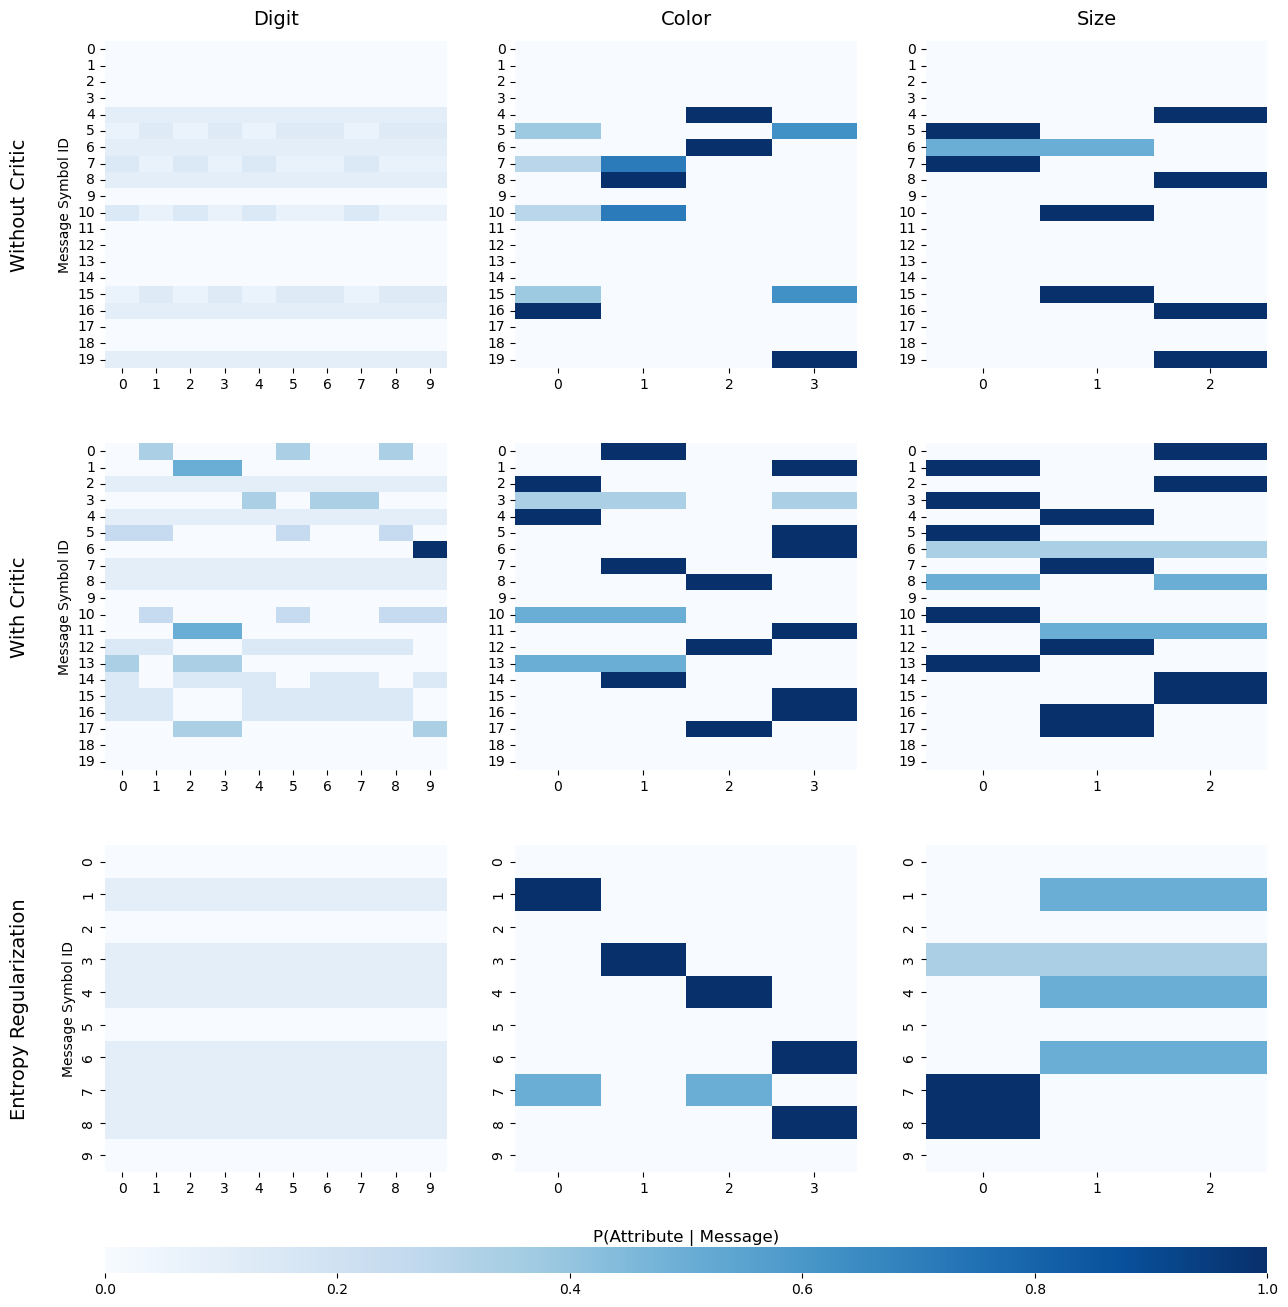

In [ ]:
fig = plt.figure(figsize=(15, 16))

# 3x3 heatmaps + 1 row for colorbar
gs = fig.add_gridspec(
    nrows=4,
    ncols=3,
    height_ratios=[1, 1, 1, 0.08],
    hspace=0.3
)

axes = np.empty((3, 3), dtype=object)
for i in range(3):
    for j in range(3):
        axes[i, j] = fig.add_subplot(gs[i, j])

# dedicated colorbar axis (bottom, spanning all columns)
cbar_ax = fig.add_subplot(gs[3, :])

conditions = ['Without Critic', 'With Critic', 'Entropy Regularization']
labels = ['Digit', 'Color', 'Size']
heatmaps_list = [maps_without_critic, maps_with_critic, maps_explore]

for i, ax_row in enumerate(axes):
    heatmaps = heatmaps_list[i]

    for j, ax in enumerate(ax_row):
        attr = labels[j]
        heatmap = heatmaps[f"P({attr} | Message)"]

        sns.heatmap(
            heatmap,
            ax=ax,
            cmap="Blues",
            vmin=0,
            vmax=1,
            cbar=(i == 0 and j == 0),   # only once
            cbar_ax=cbar_ax if (i == 0 and j == 0) else None,
            cbar_kws={"orientation": "horizontal"}
        )

        ax.set_title("")
for j, attr in enumerate(labels):
    axes[0, j].set_title(attr, fontsize=14, pad=12)
for i, cond in enumerate(conditions):
    axes[i, 0].annotate(
        cond,
        xy=(-0.25, 0.5),
        xycoords='axes fraction',
        rotation=90,
        ha='center',
        va='center',
        fontsize=14
    )
    axes[i, 0].set_ylabel("Message Symbol ID")
cbar_ax.set_xlabel("P(Attribute | Message)", fontsize=12)
cbar_ax.xaxis.set_label_position('top')

### Inspecting average cosine distance of different messages

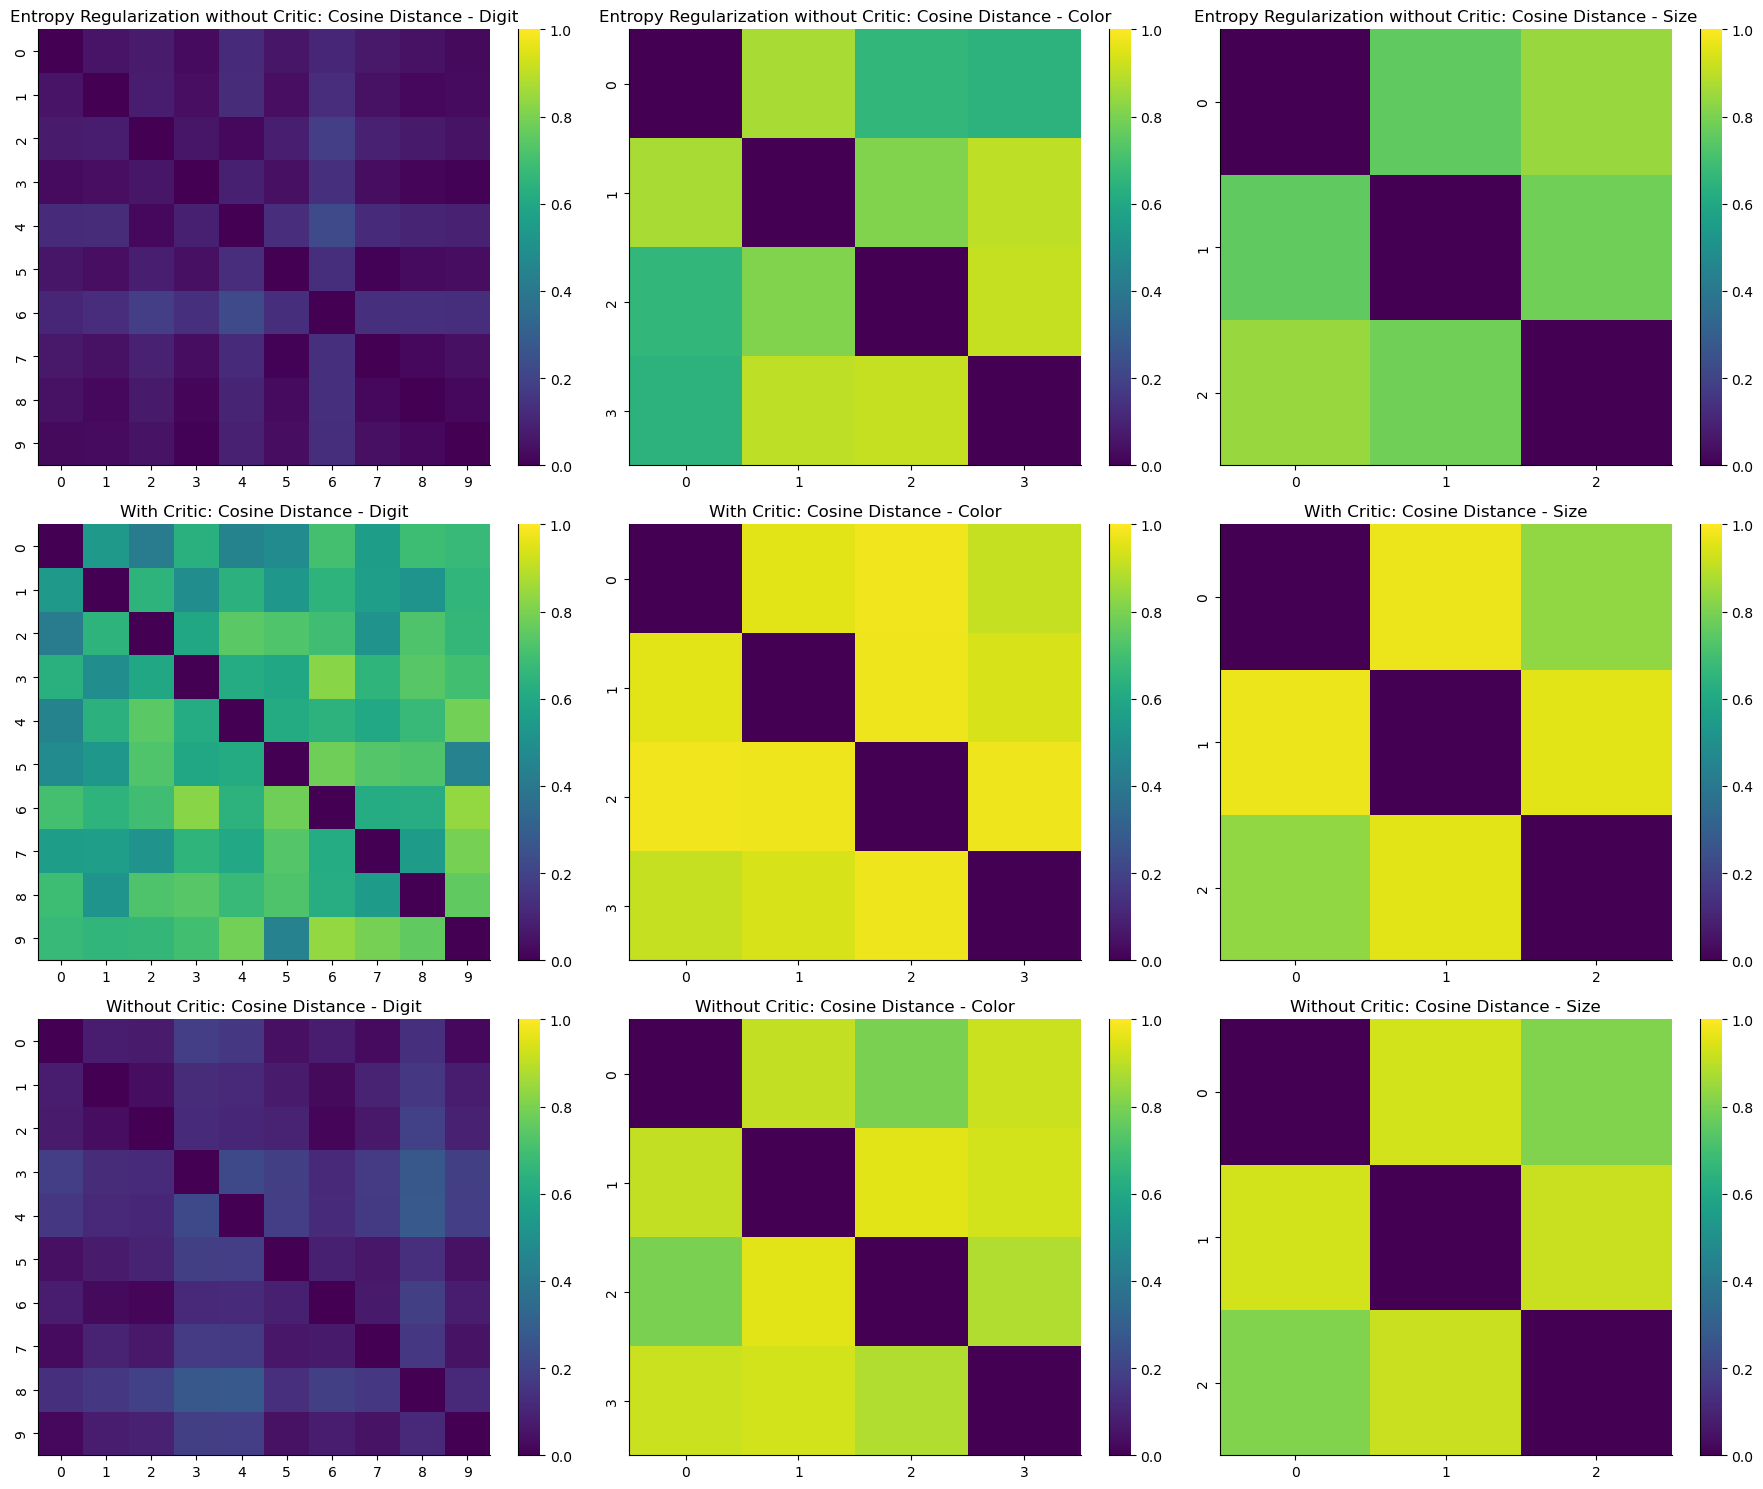

In [ ]:
# average the cosine distance matrices
D_cos_digit_explore_avg = np.mean(D_cos_digit_explore, axis=0)
D_cos_color_explore_avg = np.mean(D_cos_color_explore, axis=0)
D_cos_size_explore_avg = np.mean(D_cos_size_explore, axis=0)
D_cos_Digit_without_critic_avg = np.mean(D_cos_Digit_without_critic, axis=0)
D_cos_Color_without_critic_avg = np.mean(D_cos_Color_without_critic, axis=0)
D_cos_Size_without_critic_avg = np.mean(D_cos_Size_without_critic, axis=0)
D_cos_Digit_with_critic_avg = np.mean(D_cos_Digit_with_critic, axis=0)
D_cos_Color_with_critic_avg = np.mean(D_cos_Color_with_critic, axis=0)
D_cos_Size_with_critic_avg = np.mean(D_cos_Size_with_critic, axis=0)
# plot the averaged cosine distance matrices for all conditions
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
sns.heatmap(D_cos_digit_explore_avg, ax=axes[0, 0], cmap="viridis", vmin=0, vmax=1)
axes[0, 0].set_title("Entropy Regularization without Critic: Cosine Distance - Digit")
sns.heatmap(D_cos_color_explore_avg, ax=axes[0, 1], cmap="viridis", vmin=0, vmax=1)
axes[0, 1].set_title("Entropy Regularization without Critic: Cosine Distance - Color")
sns.heatmap(D_cos_size_explore_avg, ax=axes[0, 2], cmap="viridis", vmin=0, vmax=1)
axes[0, 2].set_title("Entropy Regularization without Critic: Cosine Distance - Size")
sns.heatmap(D_cos_Digit_with_critic_avg, ax=axes[1,0], cmap="viridis", vmin=0, vmax=1)
axes[1, 0].set_title("With Critic: Cosine Distance - Digit")
sns.heatmap(D_cos_Color_with_critic_avg, ax=axes[1,1], cmap="viridis", vmin=0, vmax=1)
axes[1, 1].set_title("With Critic: Cosine Distance - Color")
sns.heatmap(D_cos_Size_with_critic_avg, ax=axes[1,2], cmap="viridis", vmin=0, vmax=1)
axes[1, 2].set_title("With Critic: Cosine Distance - Size")
sns.heatmap(D_cos_Digit_without_critic_avg, ax=axes[2,0], cmap="viridis", vmin=0, vmax=1)
axes[2, 0].set_title("Without Critic: Cosine Distance - Digit")
sns.heatmap(D_cos_Color_without_critic_avg, ax=axes[2,1], cmap="viridis", vmin=0, vmax=1)
axes[2, 1].set_title("Without Critic: Cosine Distance - Color")
sns.heatmap(D_cos_Size_without_critic_avg, ax=axes[2,2], cmap="viridis", vmin=0, vmax=1)
axes[2, 2].set_title("Without Critic: Cosine Distance - Size")
sns.despine()
plt.tight_layout()

### Learning Curves

In [ ]:
from scipy.ndimage import gaussian_filter1d
def smooth_curve_mean(data, sigma=200):
    """
    Smooth the learning curve using a Gaussian filter.
    data: shape (num_runs, num_episodes)
    """
    smoothed = gaussian_filter1d(data, sigma=sigma, axis=1)
    mean, std = np.mean(smoothed, axis=0), np.std(smoothed, axis=0)
    return smoothed, mean, std

In [ ]:
# episode-wise permutation test p-values
# entropy regularization vs without critic
smooth_without_critic, mean_history_without_critic, std_history_without_critic = smooth_curve_mean(history_without_critic, sigma=200)
smooth_with_critic, mean_history_with_critic, std_history_with_critic = smooth_curve_mean(history_with_critic, sigma=200)
smooth_explore, mean_history_explore, std_history_explore = smooth_curve_mean(reward_history_explore, sigma=200)
p_values_explore_vs_without_critic = permutation_test(smooth_explore, smooth_without_critic, num_permutations=1000)
# with critic vs without critic
p_values_with_critic_vs_without_critic = permutation_test(smooth_with_critic, smooth_without_critic, num_permutations=1000)

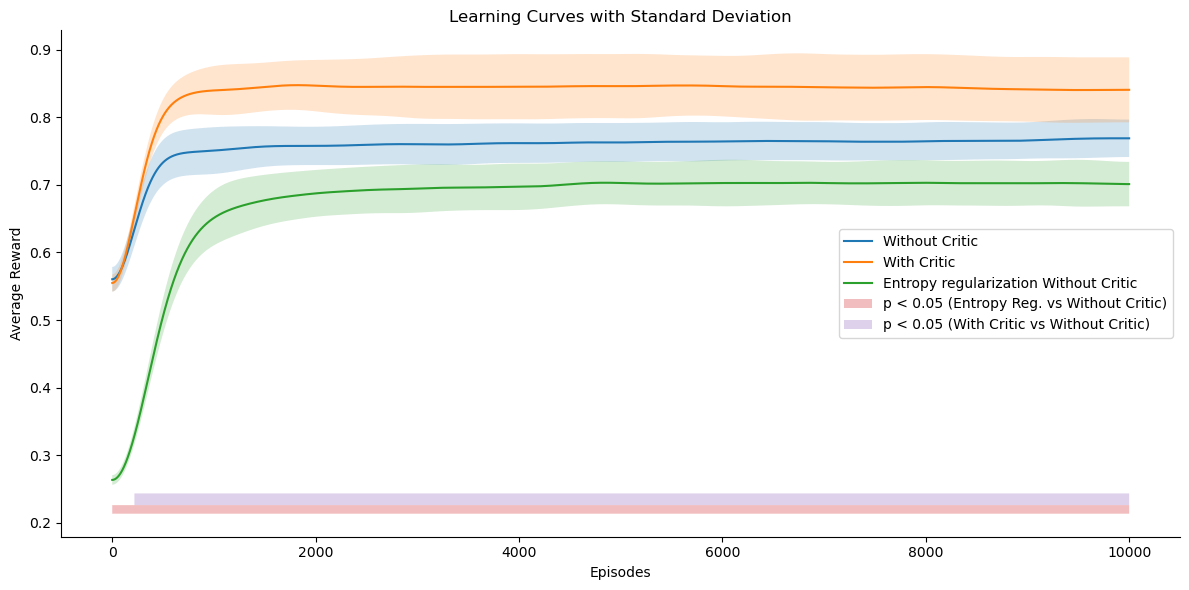

episodes with significant difference (With Critic vs Without Critic): 9782
episodes with significant difference (Entropy Reg. vs Without Critic): 10000


In [ ]:
# plot explorative learning curve
plt.figure(figsize=(12, 6))
sns.lineplot(x=np.arange(len(mean_history_without_critic)), y=mean_history_without_critic, label='Without Critic')
plt.fill_between(np.arange(len(mean_history_without_critic)),
                 mean_history_without_critic - std_history_without_critic,
                 mean_history_without_critic + std_history_without_critic, alpha=0.2)
sns.lineplot(x=np.arange(len(mean_history_with_critic)), y=mean_history_with_critic, label='With Critic')
plt.fill_between(np.arange(len(mean_history_with_critic)),
                 mean_history_with_critic - std_history_with_critic,
                 mean_history_with_critic + std_history_with_critic, alpha=0.2)
sns.lineplot(x=np.arange(len(mean_history_explore)), y=mean_history_explore, label='Entropy regularization Without Critic')
plt.fill_between(np.arange(len(mean_history_explore)),
                 mean_history_explore - std_history_explore,
                 mean_history_explore + std_history_explore, alpha=0.2)
sns.despine()
plt.title('Learning Curves with Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

# mark significant differences on the learning curve plot
alpha = 0.05
sig_explore_vs_without_critic = p_values_explore_vs_without_critic < alpha
sig_with_critic_vs_without_critic = p_values_with_critic_vs_without_critic < alpha

y_max = max(mean_history_without_critic.max(), mean_history_with_critic.max(), mean_history_explore.max())
y_min = min(mean_history_without_critic.min(), mean_history_with_critic.min(), mean_history_explore.min()) - 0.05
bar_height_explore_vs_without_critic = 0.02 * (y_max - y_min)
bar_height_with_critic_vs_without_critic = 0.02 * (y_max - y_min)

plt.fill_between(np.arange(len(mean_history_explore)),
                 y_min, y_min + bar_height_explore_vs_without_critic,
                 where=sig_explore_vs_without_critic,
                 edgecolor="none", linewidth=0.0, alpha=0.3, label='p < 0.05 (Entropy Reg. vs Without Critic)')
plt.fill_between(np.arange(len(mean_history_with_critic)),
                 y_min+0.03, y_min + bar_height_with_critic_vs_without_critic,
                 where=sig_with_critic_vs_without_critic,
                 edgecolor="none", linewidth=0.0, alpha=0.3, label='p < 0.05 (With Critic vs Without Critic)')
plt.legend()
plt.tight_layout()
plt.show()
print(f"episodes with significant difference (With Critic vs Without Critic): {np.sum(sig_with_critic_vs_without_critic)}")
print(f"episodes with significant difference (Entropy Reg. vs Without Critic): {np.sum(sig_explore_vs_without_critic)}")

### Comparing three conditions: average cosine distance across pairs and trials

In [ ]:
# helper function to plot significance stars
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'


def add_sig_bracket(ax, x1, x2, y, h, text):
    ax.plot([x1, x1, x2, x2],
            [y, y + h, y + h, y],
            lw=1.5, c='black')
    ax.text((x1 + x2) / 2, y + h,
            text, ha='center', va='bottom', fontsize=13)

In [ ]:
# average pairwise cosine distance across attributes and runs for entropy regularization
# without critic
avg_D_cos_Digit_without_critic = np.mean(D_cos_Digit_without_critic, axis=(1,2))
avg_D_cos_Color_without_critic = np.mean(D_cos_Color_without_critic, axis=(1,2))
avg_D_cos_Size_without_critic = np.mean(D_cos_Size_without_critic, axis=(1,2))
# with critic
avg_D_cos_Digit_with_critic = np.mean(D_cos_Digit_with_critic, axis=(1,2))
avg_D_cos_Color_with_critic = np.mean(D_cos_Color_with_critic, axis=(1,2))
avg_D_cos_Size_with_critic = np.mean(D_cos_Size_with_critic, axis=(1,2))
# explorative
avg_D_cos_Digit_explore = np.mean(D_cos_digit_explore, axis=(1,2))
avg_D_cos_Color_explore = np.mean(D_cos_color_explore, axis=(1,2))
avg_D_cos_Size_explore = np.mean(D_cos_size_explore, axis=(1,2))

# permutation tests
# without critic vs with critic
p_values_digit = permutation_test(avg_D_cos_Digit_without_critic.reshape(-1,1), avg_D_cos_Digit_with_critic.reshape(-1,1), num_permutations=1000)
p_values_color = permutation_test(avg_D_cos_Color_without_critic.reshape(-1,1), avg_D_cos_Color_with_critic.reshape(-1,1), num_permutations=1000)
p_values_size = permutation_test(avg_D_cos_Size_without_critic.reshape(-1,1), avg_D_cos_Size_with_critic.reshape(-1,1), num_permutations=1000)
# without critic vs explorative
p_values_digit_explore = permutation_test(avg_D_cos_Digit_without_critic.reshape(-1,1), avg_D_cos_Digit_explore.reshape(-1,1), num_permutations=1000)
p_values_color_explore = permutation_test(avg_D_cos_Color_without_critic.reshape(-1,1), avg_D_cos_Color_explore.reshape(-1,1), num_permutations=1000)
p_values_size_explore = permutation_test(avg_D_cos_Size_without_critic.reshape(-1,1), avg_D_cos_Size_explore.reshape(-1,1), num_permutations=1000)
# crictic vs explorative
p_values_digit_critic_explore = permutation_test(avg_D_cos_Digit_with_critic.reshape(-1,1), avg_D_cos_Digit_explore.reshape(-1,1), num_permutations=1000)
p_values_color_critic_explore = permutation_test(avg_D_cos_Color_with_critic.reshape(-1,1), avg_D_cos_Color_explore.reshape(-1,1), num_permutations=1000)
p_values_size_critic_explore = permutation_test(avg_D_cos_Size_with_critic.reshape(-1,1), avg_D_cos_Size_explore.reshape(-1,1), num_permutations=1000)

# plot bar charts to compare average pairwise cosine distances
labels = ['Digit', 'Color', 'Size']
conditions = ['Without Critic', 'With Critic', 'Explorative']
without_critic_means = [np.mean(avg_D_cos_Digit_without_critic), np.mean(avg_D_cos_Color_without_critic), np.mean(avg_D_cos_Size_without_critic)]
with_critic_means = [np.mean(avg_D_cos_Digit_with_critic), np.mean(avg_D_cos_Color_with_critic), np.mean(avg_D_cos_Size_with_critic)]
without_critic_stds = [np.std(avg_D_cos_Digit_without_critic), np.std(avg_D_cos_Color_without_critic), np.std(avg_D_cos_Size_without_critic)]
with_critic_stds = [np.std(avg_D_cos_Digit_with_critic), np.std(avg_D_cos_Color_with_critic), np.std(avg_D_cos_Size_with_critic)]
x = np.arange(len(labels))  # the label locations
entropy_regularization_means = [np.mean(avg_D_cos_Digit_explore), np.mean(avg_D_cos_Color_explore), np.mean(avg_D_cos_Size_explore)]
entropy_regularization_stds = [np.std(avg_D_cos_Digit_explore), np.std(avg_D_cos_Color_explore), np.std(avg_D_cos_Size_explore)]

width = 0.35  # the width of the bars
import pandas as pd
df = pd.DataFrame({
    'Attribute': labels * 3,
    'Average Cosine Distance': without_critic_means + with_critic_means + entropy_regularization_means,
    'Std Dev': without_critic_stds + with_critic_stds + entropy_regularization_stds,
    'Condition': ['Without Critic'] * 3 + ['With Critic'] * 3 + ['Entropy Regularization'] * 3
})

/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_68681/1408044848.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ('Without Critic', 'With Critic'): float(p_values_digit),
/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_68681/1408044848.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ('Without Critic', 'Entropy Regularization'): float(p_values_digit_explore),
/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_68681/1408044848.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

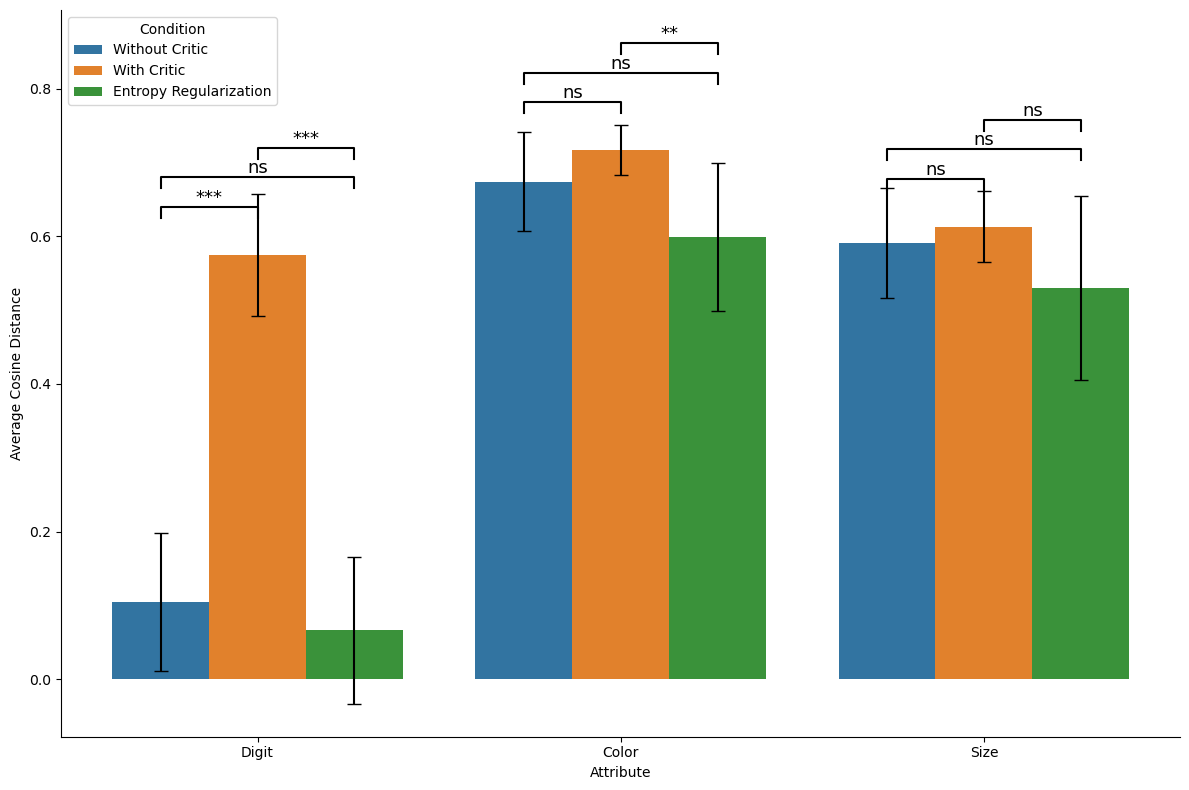

In [ ]:
conditions = ['Without Critic', 'With Critic', 'Entropy Regularization']
labels = ['Digit', 'Color', 'Size']

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df,
    x='Attribute',
    y='Average Cosine Distance',
    hue='Condition',
    ax=ax,
    capsize=0
)
n_cond = len(conditions)
group_width = 0.8
bar_width = group_width / n_cond

offsets = np.linspace(
    -group_width/2 + bar_width/2,
     group_width/2 - bar_width/2,
     n_cond
)

for a_idx, attr in enumerate(labels):
    for c_idx, cond in enumerate(conditions):
        row = df[(df.Attribute == attr) & (df.Condition == cond)].iloc[0]

        x = a_idx + offsets[c_idx]
        y = row['Average Cosine Distance']
        yerr = row['Std Dev']

        ax.errorbar(
            x, y,
            yerr=yerr,
            fmt='none',
            ecolor='black',
            capsize=5,
            lw=1.5
        )
pval_map = {
    'Digit': {
        ('Without Critic', 'With Critic'): float(p_values_digit),
        ('Without Critic', 'Entropy Regularization'): float(p_values_digit_explore),
        ('With Critic', 'Entropy Regularization'): float(p_values_digit_critic_explore)
    },
    'Color': {
        ('Without Critic', 'With Critic'): float(p_values_color),
        ('Without Critic', 'Entropy Regularization'): float(p_values_color_explore),
        ('With Critic', 'Entropy Regularization'): float(p_values_color_critic_explore)
    },
    'Size': {
        ('Without Critic', 'With Critic'): float(p_values_size),
        ('Without Critic', 'Entropy Regularization'): float(p_values_size_explore),
        ('With Critic', 'Entropy Regularization'): float(p_values_size_critic_explore)
    }
}
for a_idx, attr in enumerate(labels):
    y_max = df[df.Attribute == attr]['Average Cosine Distance'].max()
    base_y = y_max + 0.05
    step = 0.04

    for k, ((c1, c2), p) in enumerate(pval_map[attr].items()):
        i1 = conditions.index(c1)
        i2 = conditions.index(c2)

        x1 = a_idx + offsets[i1]
        x2 = a_idx + offsets[i2]

        add_sig_bracket(
            ax,
            x1, x2,
            base_y + k * step,
            h=0.015,
            text=p_to_star(p)
        )
sns.despine()
plt.tight_layout()
plt.show()

### Visualizing weight distribution of Alice network

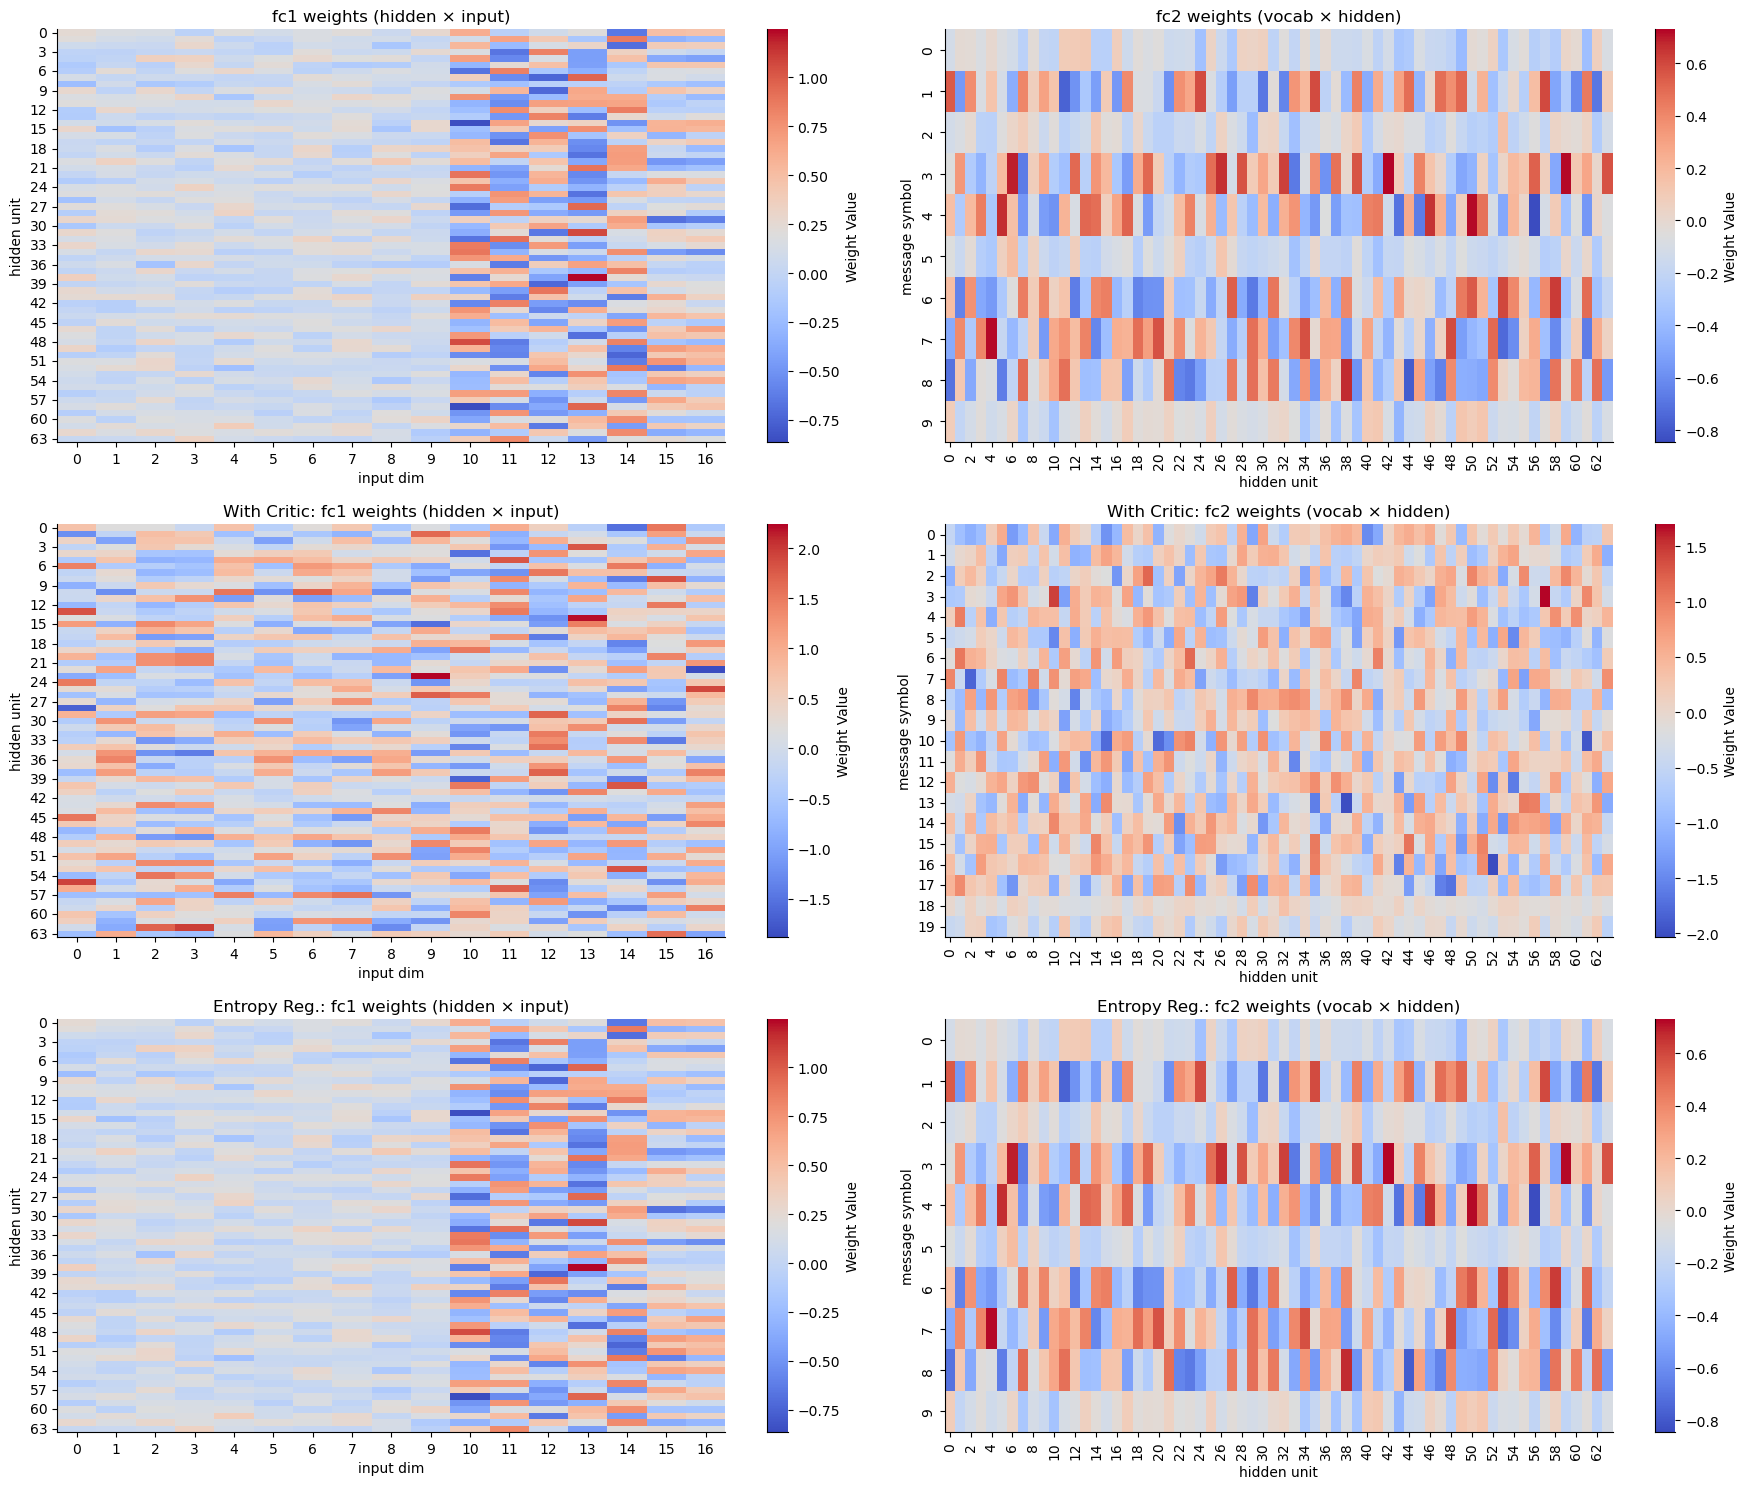

In [ ]:
# trained Alice
import matplotlib.pyplot as plt

W1 = trained_alice.fc1.weight.detach().cpu()   # (H, D)
W2 = trained_alice.fc2.weight.detach().cpu()   # (V, H)

W1_critic = trained_alice_critic.fc1.weight.detach().cpu()   # (H, D)
W2_critic = trained_alice_critic.fc2.weight.detach().cpu()   # (V, H)

W1_entropy = trained_alice_explore.fc1.weight.detach().cpu()   # (H, D)
W2_entropy = trained_alice_explore.fc2.weight.detach().cpu()   # (V, H)

# plot heatmaps of the weight matrices for all conditions
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
sns.heatmap(W1, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[0, 0])
axes[0, 0].set_title("fc1 weights (hidden × input)")
axes[0, 0].set_xlabel("input dim")
axes[0, 0].set_ylabel("hidden unit")
sns.heatmap(W2, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[0, 1])
axes[0, 1].set_title("fc2 weights (vocab × hidden)")
axes[0, 1].set_xlabel("hidden unit")
axes[0, 1].set_ylabel("message symbol")
sns.heatmap(W1_critic, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[1, 0])
axes[1, 0].set_title("With Critic: fc1 weights (hidden × input)")
axes[1, 0].set_xlabel("input dim")
axes[1, 0].set_ylabel("hidden unit")
sns.heatmap(W2_critic, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[1, 1])
axes[1, 1].set_title("With Critic: fc2 weights (vocab × hidden)")
axes[1, 1].set_xlabel("hidden unit")
axes[1, 1].set_ylabel("message symbol")
sns.heatmap(W1_entropy, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[2, 0])
axes[2, 0].set_title("Entropy Reg.: fc1 weights (hidden × input)")
axes[2, 0].set_xlabel("input dim")
axes[2, 0].set_ylabel("hidden unit")
sns.heatmap(W2_entropy, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[2, 1])
axes[2, 1].set_title("Entropy Reg.: fc2 weights (vocab × hidden)")
axes[2, 1].set_xlabel("hidden unit")
axes[2, 1].set_ylabel("message symbol")
sns.despine()
plt.tight_layout()
plt.show()

## Symbolic game with sequential messages

**Exercise 2 (extended baseline)** This is the same exercise as the previous one. This time the message is a sequence of symbols generated by an LSTM language model. Alice generates a string and Bob has to encode it in a vector. You may limit the maximum size of the message. Explain whether you can interpret the messages. Design experiments to get explanations. Explain what you did and to which extent you can interpret the generated language

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein
from scipy.stats import pearsonr

In [ ]:
# --- Configuration ---
BATCH_SIZE = 64
EPISODES = 25000
LEARNING_RATE = 0.001
K_IMAGES = 5
VOCAB_SIZE = 10   # Symbols 0-9
MAX_LEN = 5       # Max sequence length
EOS_TOKEN = 0     # Reserved index for "End of Sentence"

EMBEDDING_DIM = 32
HIDDEN_DIM = 64
BETA = 0.005  # Entropy regularization coefficient
# Attributes (Same as before)
N_DIGITS = 10
N_COLORS = 4
N_SIZES = 3
INPUT_DIM = N_DIGITS + N_COLORS + N_SIZES

In [ ]:
class Nature:
    """Generates the game state."""
    @staticmethod
    def get_batch(batch_size, k):
        digits = torch.randint(0, N_DIGITS, (batch_size, k))
        colors = torch.randint(0, N_COLORS, (batch_size, k))
        sizes = torch.randint(0, N_SIZES, (batch_size, k))
        return torch.stack([digits, colors, sizes], dim=2)

    @staticmethod
    def to_one_hot(tensor_batch):
        b, k, _ = tensor_batch.shape
        digits = tensor_batch[:, :, 0]
        colors = tensor_batch[:, :, 1]
        sizes = tensor_batch[:, :, 2]

        oh_d = F.one_hot(digits, N_DIGITS)
        oh_c = F.one_hot(colors, N_COLORS)
        oh_s = F.one_hot(sizes, N_SIZES)

        return torch.cat([oh_d, oh_c, oh_s], dim=2).float()

In [ ]:
class AliceLSTM(nn.Module):
    def __init__(self):
        super(AliceLSTM, self).__init__()
        # Visual Encoder
        self.feat_encoder = nn.Linear(INPUT_DIM, HIDDEN_DIM)

        # LSTM Core
        self.embedding = nn.Embedding(VOCAB_SIZE, HIDDEN_DIM)
        self.lstm_cell = nn.LSTMCell(HIDDEN_DIM, HIDDEN_DIM)
        self.out_layer = nn.Linear(HIDDEN_DIM, VOCAB_SIZE)
        self.MAX_LEN = MAX_LEN

    def forward(self, target_input):
        # target_input: (Batch, INPUT_DIM)

        # Initialize hidden state with image features
        h = F.relu(self.feat_encoder(target_input))
        c = torch.zeros_like(h)

        # Start token (e.g., zeros) or learnable parameter.
        # Here we assume standard start is just a zero-vector embedding input
        curr_input = torch.zeros(target_input.size(0), HIDDEN_DIM).to(target_input.device)

        log_probs = []
        entropy = []
        messages = [] # List of (Batch) tensors

        # Active mask (1 if sentence continues, 0 if ended)
        active_mask = torch.ones(target_input.size(0)).to(target_input.device)

        for t in range(MAX_LEN):
            h, c = self.lstm_cell(curr_input, (h, c))
            logits = self.out_layer(h)
            probs = F.softmax(logits, dim=1)

            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            # Save stats
            log_probs.append(dist.log_prob(action) * active_mask)
            entropy.append(dist.entropy() * active_mask)
            messages.append(action)

            # Update inputs for next step
            curr_input = self.embedding(action)

            # Update mask: if action was EOS (0), mask becomes 0
            is_eos = (action == EOS_TOKEN).float()
            active_mask = active_mask * (1 - is_eos)

        return torch.stack(messages, dim=1), torch.stack(log_probs, dim=1), torch.stack(entropy, dim=1)

In [ ]:
class BobLSTM(nn.Module):
    def __init__(self):
        super(BobLSTM, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, HIDDEN_DIM)
        self.lstm = nn.LSTM(HIDDEN_DIM, HIDDEN_DIM, batch_first=True)
        self.img_encoder = nn.Linear(INPUT_DIM, HIDDEN_DIM)

    def forward(self, messages, candidates):
        # messages: (Batch, Seq_Len)
        # candidates: (Batch, K, Input_Dim)

        # 1. Encode Message
        # Embed indices
        x = self.embedding(messages) # (Batch, Seq, Hidden)

        # Run LSTM. We only care about the final hidden state
        # (Assuming the network learns to ignore padding after EOS or EOS is final)
        _, (h_n, _) = self.lstm(x)
        msg_rep = h_n.squeeze(0).unsqueeze(1) # (Batch, 1, Hidden)

        # 2. Encode Images
        img_reps = self.img_encoder(candidates) # (Batch, K, Hidden)

        # 3. Attention / Dot Product
        scores = torch.bmm(img_reps, msg_rep.transpose(1, 2)).squeeze(2) # (Batch, K)
        probs = F.softmax(scores, dim=1)
        dist = torch.distributions.Categorical(probs)
        entropy = dist.entropy()
        guess = dist.sample()
        log_prob = dist.log_prob(guess)

        return guess, log_prob, entropy

In [ ]:
class centralizedSeqCritic(nn.Module):
    def __init__(self):
        super(centralizedSeqCritic, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM + VOCAB_SIZE, HIDDEN_DIM)
        self.lstm = nn.LSTM(HIDDEN_DIM, HIDDEN_DIM, batch_first=True)
        self.fc2 = nn.Linear(HIDDEN_DIM, 1)

    def forward(self, candidates, message):
        # candidates: (Batch, K, Input_Dim)
        # message: (Batch, Seq_Len)

        # Flatten candidates
        batch_size = candidates.size(0)
        k = candidates.size(1)
        candidates_flat = candidates.view(batch_size * k, -1) # (Batch*K, Input_Dim)

        # One-hot encode message (take only first symbol for simplicity)
        msg_onehot = F.one_hot(message[:, 0], VOCAB_SIZE).float() # (Batch, Vocab)
        msg_onehot_expanded = msg_onehot.unsqueeze(1).expand(-1, k, -1).contiguous()
        msg_onehot_flat = msg_onehot_expanded.view(batch_size * k, -1) # (Batch*K, Vocab)

        # Concatenate
        critic_input = torch.cat([candidates_flat, msg_onehot_flat], dim=1) # (Batch*K, Input_Dim + Vocab)

        h = F.relu(self.fc1(critic_input))
        h, _ = self.lstm(h.unsqueeze(1)) # (Batch*K, 1, Hidden)
        h = h.squeeze(1) # (Batch*K, Hidden)
        values = torch.sigmoid(self.fc2(h)).view(batch_size, k) # (Batch, K)

        # For simplicity, return value corresponding to the first candidate
        return values[:, 0]

In [ ]:
def train_sequence_game(verbose=False):
    alice = AliceLSTM()
    bob = BobLSTM()
    optimizer = optim.Adam(list(alice.parameters()) + list(bob.parameters()), lr=LEARNING_RATE)

    history = []
    running_reward = 0

    pbar = tqdm.tqdm(range(EPISODES), desc="Training with Critic")
    for episode in pbar:
        raw_batch = Nature.get_batch(BATCH_SIZE, K_IMAGES)
        batch_oh = Nature.to_one_hot(raw_batch)
        target = batch_oh[:, 0, :]

        # Alice Generates
        msgs, alice_lp, alice_ent = alice(target)

        # Bob Guesses
        guess, bob_lp, _ = bob(msgs, batch_oh)

        # Reward
        rewards = (guess == 0).float()
        mean_r = rewards.mean().item()

        running_reward = 0.95 * running_reward + 0.05 * mean_r

        # Loss Calculation
        # Alice's loss is sum of log_probs over time
        alice_loss = - (alice_lp.sum(dim=1) * (rewards - running_reward)).mean()
        # Entropy regularization to encourage exploration
        alice_loss -= 0.01 * alice_ent.sum(dim=1).mean()

        bob_loss = - (bob_lp * (rewards - running_reward)).mean()

        loss = alice_loss + bob_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(mean_r)

        pbar.set_postfix({'Reward': mean_r, 'loss': loss.item()})
        if episode % 1000 == 0 and verbose:
            print(f"Ep {episode}: Reward {mean_r:.3f}")

    return alice, history

In [ ]:
def train_sequence_game_with_critic(verbose=False):
    alice = AliceLSTM()
    bob = BobLSTM()
    critic = centralizedSeqCritic()
    optimizer = optim.Adam(list(alice.parameters()) + list(bob.parameters()) + list(critic.parameters()), lr=LEARNING_RATE)

    history = []
    running_reward = 0

    pbar = tqdm.tqdm(range(EPISODES), desc="Training with Critic")
    for episode in pbar:
        raw_batch = Nature.get_batch(BATCH_SIZE, K_IMAGES)
        batch_oh = Nature.to_one_hot(raw_batch)
        target = batch_oh[:, 0, :]

        # Alice Generates
        msgs, alice_lp, alice_ent = alice(target)

        # Bob Guesses
        guess, bob_lp, bob_ent = bob(msgs, batch_oh)

        # Critic Estimates
        values = critic(batch_oh, msgs).squeeze()  # (Batch)

        # Reward
        rewards = (guess == 0).float()
        mean_r = rewards.mean().item()

        # Advantage
        advantages = rewards - values.detach()

        # Loss Calculation
        alice_loss = - (alice_lp.sum(dim=1) * advantages).mean()
        alice_loss -= 0.01 * alice_ent.sum(dim=1).mean()

        bob_loss = - (bob_lp * advantages).mean()

        # entropy regularization for both
        entropy_bob_loss = - BETA * bob_ent.mean()
        entropy_alice_loss = - BETA * alice_ent.mean()

        critic_loss = F.mse_loss(values, rewards)

        loss = alice_loss + bob_loss + entropy_alice_loss + entropy_bob_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(mean_r)

        pbar.set_postfix({'Reward': mean_r, 'loss': loss.item()})
        if episode % 1000 == 0 and verbose:
            print(f"Ep {episode}: Reward {mean_r:.3f}")

    return alice, history

In [ ]:
# Compute Topographic Similarity as in the paper

def analyze_topographic_similarity(alice, verbose=False):
    """
    Computes correlation between Input Distance (Attribute Hamming dist)
    and Output Distance (Levenshtein dist of messages).
    High correlation implies compositional structure.
    """
    if verbose:
        print("\n--- Topographic Similarity Analysis ---")
    alice.eval()

    # Generate random sample of inputs
    N_SAMPLES = 100
    raw = Nature.get_batch(N_SAMPLES, 1).squeeze(1) # (N, 3)
    inputs_oh = Nature.to_one_hot(raw.unsqueeze(1)).squeeze(1)

    # Get messages
    with torch.no_grad():
        msgs_tensor, _, _ = alice(inputs_oh)

    msgs_list = msgs_tensor.tolist()
    # Convert to strings for Levenshtein (ignoring EOS padding for visual, keeping for calc)
    str_msgs = ["".join([str(t) for t in m if t != EOS_TOKEN]) for m in msgs_list]

    input_dists = []
    msg_dists = []

    # Compare all pairs
    for i in range(N_SAMPLES):
        for j in range(i+1, N_SAMPLES):
            # Input distance: Hamming distance between (d,c,s) tuples
            # (Count how many attributes differ)
            dist_in = np.sum(raw[i].numpy() != raw[j].numpy())

            # Message distance: Levenshtein
            dist_msg = Levenshtein.distance(str_msgs[i], str_msgs[j])

            input_dists.append(dist_in)
            msg_dists.append(dist_msg)

    # Calculate Correlation
    corr, _ = pearsonr(input_dists, msg_dists)
    if verbose:
        print(f"Topographic Similarity (Pearson Corr): {corr:.4f}")


        plt.figure(figsize=(6,6))
        sns.violinplot(x=input_dists, y=msg_dists)
        plt.xlabel("Attribute Distance (Hamming)")
        plt.ylabel("Message Distance (Levenshtein)")
        plt.title(f"Compositionality check (Corr: {corr:.2f})")
        plt.show()

        # Print a few examples
        print("\nExample Translations:")
        for k in range(10):
            attrs = raw[k].tolist() # [D, C, S]
            msg = str_msgs[k]
            print(f"Input: {attrs} (D={attrs[0]}, C={attrs[1]}, S={attrs[2]}) -> Msg: {msg}")

    return corr, input_dists, msg_dists

### Training (Repeat 10 times)

In [ ]:
num_runs = 10
history_seq_without_critic = np.zeros((num_runs, EPISODES))
history_seq_with_critic = np.zeros((num_runs, EPISODES))
input_dists_all = {"without_critic": [], "with_critic": []}
msg_dists_all = {"without_critic": [], "with_critic": []}
corrs_without_critic = []
corrs_with_critic = []
for run in range(num_runs):
    print(f"\n=== Training Run {run+1}/{num_runs} WITHOUT Critic ===")
    trained_alice, history = train_sequence_game()
    history_seq_without_critic[run] = history
    corr, input_dists, msg_dists = analyze_topographic_similarity(trained_alice)
    input_dists_all["without_critic"].append(input_dists)
    msg_dists_all["without_critic"].append(msg_dists)
    corrs_without_critic.append(corr)

    print(f"\n=== Training Run {run+1}/{num_runs} WITH Critic ===")
    trained_alice_critic, history_critic = train_sequence_game_with_critic()
    history_seq_with_critic[run] = history_critic
    corr_critic, input_dists_critic, msg_dists_critic = analyze_topographic_similarity(trained_alice_critic)
    input_dists_all["with_critic"].append(input_dists_critic)
    msg_dists_all["with_critic"].append(msg_dists_critic)
    corrs_with_critic.append(corr_critic)


=== Training Run 1/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 1/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 2/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 2/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 3/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 3/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 4/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 4/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 5/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 5/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 6/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 6/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 7/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 7/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 8/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 8/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 9/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 9/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 10/10 WITHOUT Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Training Run 10/10 WITH Critic ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

### Learning Curves

In [ ]:
# plot learning curves
smooth_seq_without_critic, mean_history_seq_without_critic, std_history_seq_without_critic = smooth_curve_mean(history_seq_without_critic)
smooth_seq_with_critic, mean_history_seq_with_critic, std_history_seq_with_critic = smooth_curve_mean(history_seq_with_critic, )
# episode-wise permutation test p-values
p_values_seq_critic_vs_without_critic = permutation_test(smooth_seq_with_critic, smooth_seq_without_critic, num_permutations=1000)

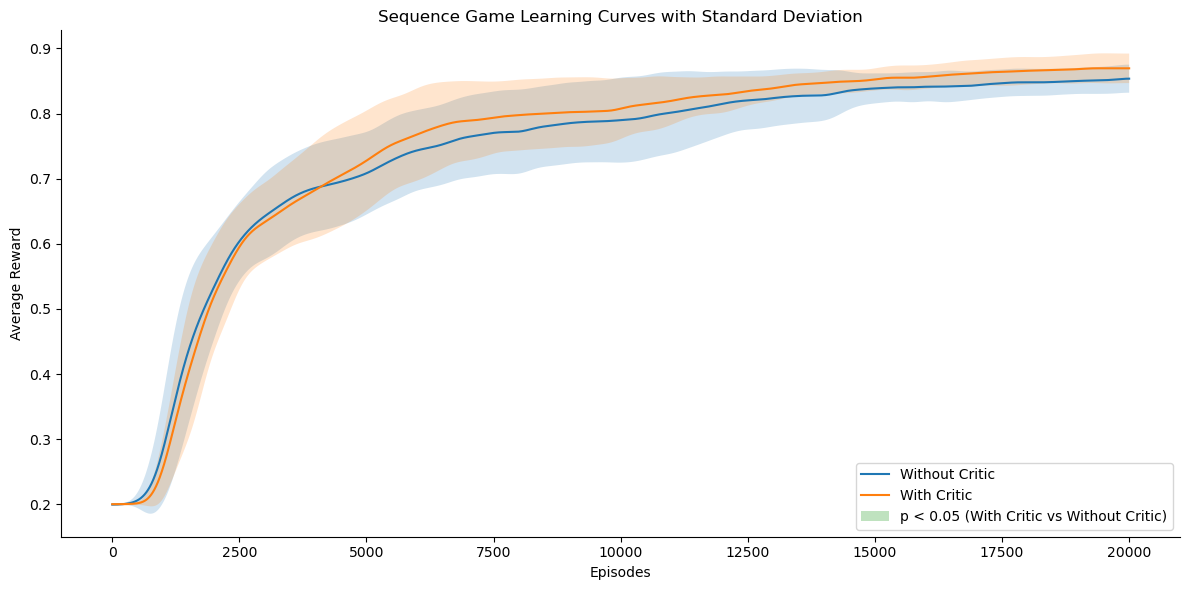

episodes with significant difference (With Critic vs Without Critic): 0


In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=np.arange(EPISODES), y=mean_history_seq_without_critic, label='Without Critic')
plt.fill_between(np.arange(EPISODES),
                 mean_history_seq_without_critic - std_history_seq_without_critic,
                 mean_history_seq_without_critic + std_history_seq_without_critic, alpha=0.2)
sns.lineplot(x=np.arange(EPISODES), y=mean_history_seq_with_critic, label='With Critic')
plt.fill_between(np.arange(EPISODES),
                 mean_history_seq_with_critic - std_history_seq_with_critic,
                 mean_history_seq_with_critic + std_history_seq_with_critic, alpha=0.2)
sns.despine()
plt.title('Sequence Game Learning Curves with Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
# mark significant differences on the learning curve plot
alpha = 0.05
sig_seq_critic_vs_without_critic = p_values_seq_critic_vs_without_critic < alpha
y_max = max(mean_history_seq_without_critic.max(), mean_history_seq_with_critic.max())
y_min = min(mean_history_seq_without_critic.min(), mean_history_seq_with_critic.min()) - 0.05
bar_height_seq_critic_vs_without_critic = 0.02 * (y_max - y_min)
plt.fill_between(np.arange(EPISODES),
                 y_min, y_min + bar_height_seq_critic_vs_without_critic,
                 where=sig_seq_critic_vs_without_critic,
                 edgecolor="none", linewidth=0.0, alpha=0.3, label='p < 0.05 (With Critic vs Without Critic)')
plt.legend()
plt.tight_layout()
plt.show()
print(f"episodes with significant difference (With Critic vs Without Critic): {np.sum(sig_seq_critic_vs_without_critic)}")

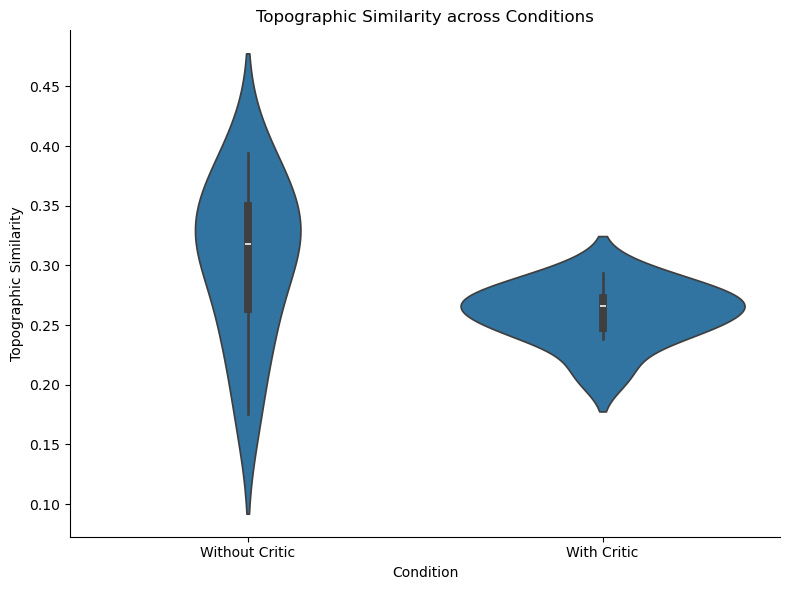

In [ ]:
corrs_without_critic = np.array(corrs_without_critic)
corrs_with_critic = np.array(corrs_with_critic)
corrsdf = pd.DataFrame({
    'Topographic Similarity': np.concatenate([corrs_without_critic, corrs_with_critic]),
    'Condition': ['Without Critic'] * num_runs + ['With Critic'] * num_runs
})
plt.figure(figsize=(8,6))
sns.violinplot(data=corrsdf, x='Condition', y='Topographic Similarity')
sns.despine()
plt.title('Topographic Similarity across Conditions')
plt.tight_layout()
plt.show()

- From above, we could see using a parametrised $Q(s|a)$ learned by regressing with ongoing rewards leads to a more stable stable compositional languages. Hence, we will use this version as the basis of our downstream analysis.

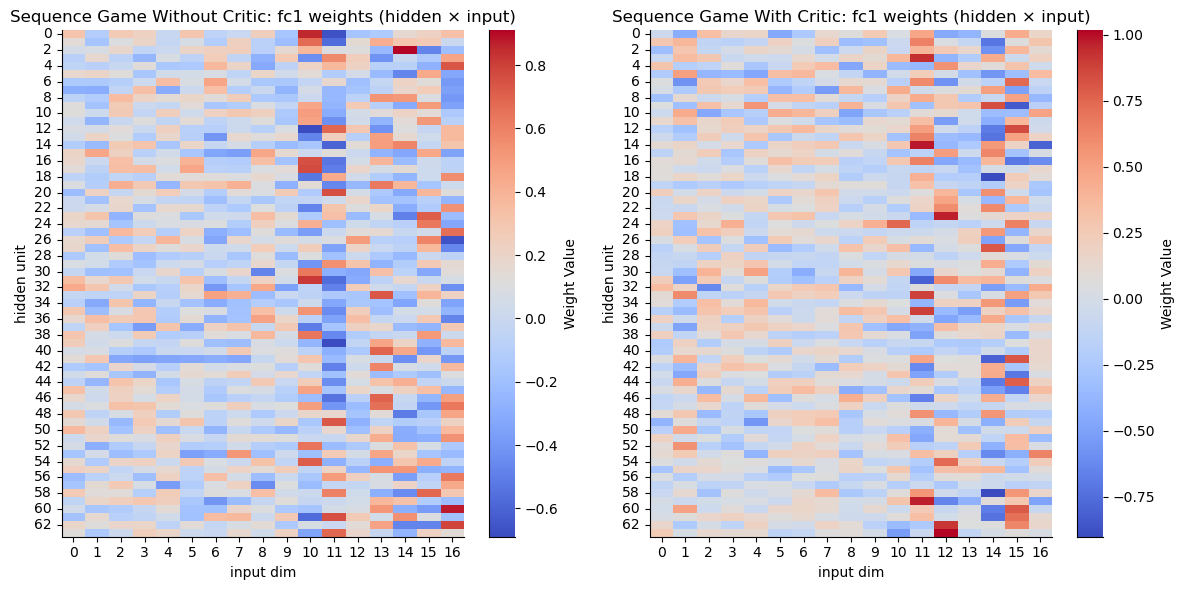

In [ ]:
W1_seq = trained_alice.feat_encoder.weight.detach().cpu()   # (H, D)
W1_seq_critic = trained_alice_critic.feat_encoder.weight.detach().cpu()   # (H, D)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(W1_seq, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[0])
axes[0].set_title("Sequence Game Without Critic: fc1 weights (hidden × input)")
axes[0].set_xlabel("input dim")
axes[0].set_ylabel("hidden unit")
sns.heatmap(W1_seq_critic, cmap='coolwarm', cbar_kws={'label': 'Weight Value'}, ax=axes[1])
axes[1].set_title("Sequence Game With Critic: fc1 weights (hidden × input)")
axes[1].set_xlabel("input dim")
axes[1].set_ylabel("hidden unit")
sns.despine()
plt.tight_layout()
plt.show()

### Investigating the effect of maximum sequence length on performance and compositionality

In [ ]:
MAX_LEN = 3
num_runs_per_len = 10 # to reduce computation time
num_lens = 7
history_len_with_critic_all = {MAX_LEN + i: [] for i in range(num_lens)}
corrs_len_with_critic_all = {MAX_LEN + i: [] for i in range(num_lens)}
input_dists_all = {MAX_LEN + i: [] for i in range(num_lens)}
msg_dists_all = {MAX_LEN + i: [] for i in range(num_lens)}
for i in range(num_lens):
    curr_len = MAX_LEN + i
    print(f"\n=== Analyzing Sequence Length {curr_len} ===")
    history_len_with_critic = np.zeros((num_runs_per_len, EPISODES))
    for run in range(num_runs_per_len):
        trained_alice_len_critic, history_len_critic = train_sequence_game_with_critic()
        history_len_with_critic[run] = history_len_critic
        corr_len_critic, input_dists, msg_dists = analyze_topographic_similarity(trained_alice_len_critic)
        input_dists_all[curr_len].append(input_dists)
        msg_dists_all[curr_len].append(msg_dists)
        corrs_len_with_critic_all[curr_len].append(corr_len_critic)

    # store or analyze learning curves as needed
    history_len_with_critic_all[curr_len] = history_len_with_critic



=== Analyzing Sequence Length 3 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Analyzing Sequence Length 4 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Analyzing Sequence Length 5 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Analyzing Sequence Length 6 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Analyzing Sequence Length 7 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Analyzing Sequence Length 8 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]


=== Analyzing Sequence Length 9 ===


Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Training with Critic:   0%|          | 0/20000 [00:00<?, ?it/s]

Correlation between Sequence Length and Topographic Similarity: 0.2696
P-value: 0.5588


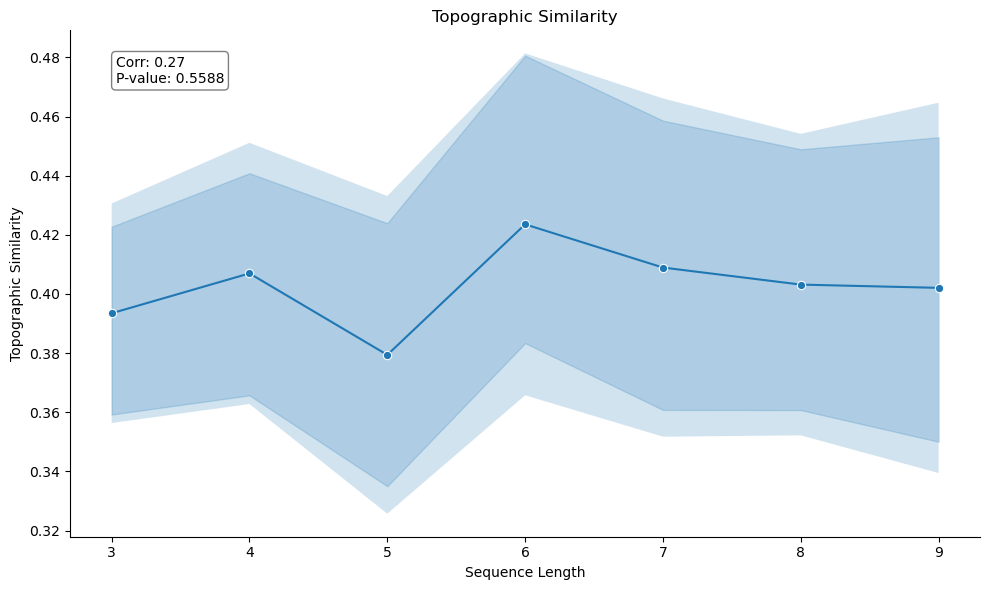

In [ ]:
corrs_len_with_critic_all_array = {k: np.array(v) for k, v in corrs_len_with_critic_all.items()}
mean_corrs_len_with_critic = {k: np.mean(v) for k, v in corrs_len_with_critic_all_array.items()}
std_corrs_len_with_critic = {k: np.std(v) for k, v in corrs_len_with_critic_all_array.items()}
corrs_lens_df = pd.DataFrame({
    'Sequence Length': np.repeat(list(mean_corrs_len_with_critic.keys()), num_runs_per_len),
    'Topographic Similarity': np.concatenate(list(corrs_len_with_critic_all_array.values()))
})
## corr between topographic similarity and sequence length
corr, p_value = pearsonr(list(mean_corrs_len_with_critic.keys()), list(mean_corrs_len_with_critic.values()))
print(f"Correlation between Sequence Length and Topographic Similarity: {corr:.4f}")
print(f"P-value: {p_value:.4f}")
plt.figure(figsize=(10, 6))
sns.lineplot(data=corrs_lens_df, x='Sequence Length', y='Topographic Similarity', marker='o')
plt.fill_between(list(mean_corrs_len_with_critic.keys()),
                 [mean_corrs_len_with_critic[k] - std_corrs_len_with_critic[k] for k in mean_corrs_len_with_critic.keys()],
                 [mean_corrs_len_with_critic[k] + std_corrs_len_with_critic[k] for k in mean_corrs_len_with_critic.keys()], alpha=0.2)
sns.despine()
# add correlation info to the plot
plt.text(0.05, 0.95, f'Corr: {corr:.2f}\nP-value: {p_value:.4f}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.title('Topographic Similarity')
plt.xlabel('Sequence Length')
plt.ylabel('Topographic Similarity')
plt.tight_layout()
plt.show()

In [ ]:
# convert each max_len input_dists and msg_dists to np.arrays
for k in input_dists_all.keys():
    input_dists_all[k] = np.array(input_dists_all[k]) # (num_runs_per_len, num_pairs)
    msg_dists_all[k] = np.array(msg_dists_all[k]) # (num_runs_per_len, num_pairs)

dist_seq_len_df = pd.DataFrame({
    'Input Distance': np.concatenate([input_dists_all[k].flatten() for k in input_dists_all.keys()]),
    'Message Distance': np.concatenate([msg_dists_all[k].flatten() for k in msg_dists_all.keys()]),
    'Sequence Length': np.concatenate([[k] * input_dists_all[k].size for k in input_dists_all.keys()])
})

<Figure size 1000x800 with 0 Axes>

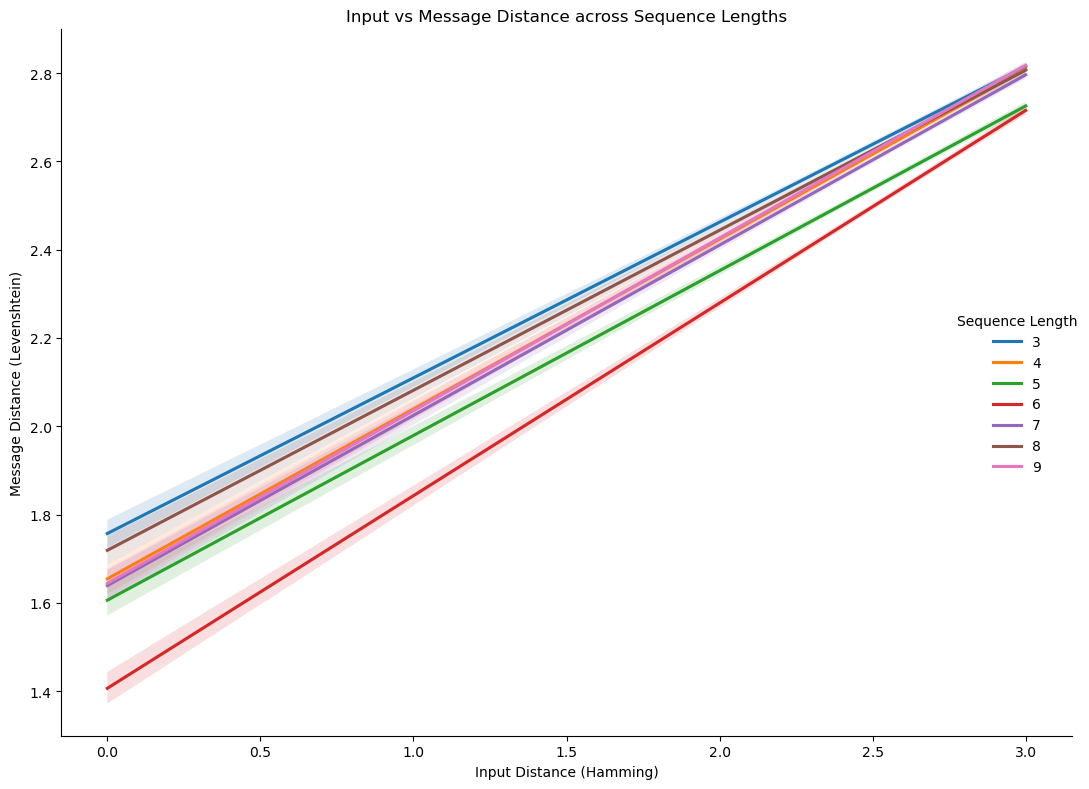

In [ ]:
# regression line across all lengths
# regression line +- confidence interval plot
plt.figure(figsize=(10, 8))
sns.lmplot(data=dist_seq_len_df, x='Input Distance', y='Message Distance', hue='Sequence Length', height=8, aspect=1.2, scatter=False)
sns.despine()
plt.title('Input vs Message Distance across Sequence Lengths')
plt.xlabel('Input Distance (Hamming)')
plt.ylabel('Message Distance (Levenshtein)')
plt.tight_layout()
plt.show()

## Referential game

The referential game makes the symbolic game more realistic by taking as input true images rather than symbolic data. We will use the [MNIST dataset](https://huggingface.co/datasets/ylecun/mnist)

### Dataset

First we download the MNIST dataset using pytorch. The MNIST data set
is a dataset of grayscale images of digits.

torch.Size([1, 28, 28])


/Users/yingcai/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/yingcai/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/yingcai/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/yingcai/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/yingcai/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/yingcai/opt/anaconda3/envs/nlp/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/yingcai/opt/anaconda3/envs/nlp/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, 

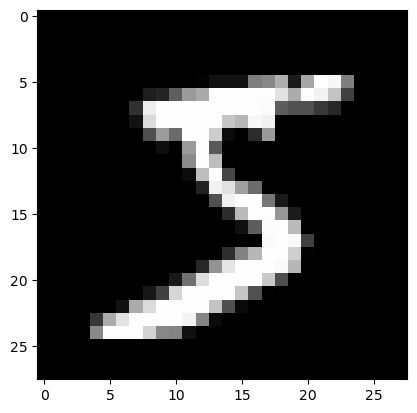

In [9]:
import torchvision
from torchvision.datasets import MNIST

dataset = MNIST("data",download=True)

import matplotlib.pyplot as plt
image, value = dataset[0]
plt.imshow(image,cmap='gray') #we tell explicitly matplotlib that the image is grayscale
from torchvision.transforms.functional import pil_to_tensor

imgtensor = pil_to_tensor(image)
print(imgtensor.shape)


We turn the image to a standard pytorch tensor

In [10]:
from torchvision.transforms.v2 import functional
from torchvision.transforms import v2
from torchvision.transforms import ToPILImage
from IPython.display import display


img_rbg = functional.grayscale_to_rgb(imgtensor)
print(img_rbg.shape)
topil = ToPILImage() # before nullify color

display(topil(img_rbg))
# img_rbg[0] = 0
img_rbg[1] = 0
img_rbg[2] = 0

display(topil(img_rbg)) # after

torch.Size([3, 28, 28])


### Data transformation

The basic images are annotated with the digit values only.
Here you want to add other attributes to the image:
such as color (red, green or blue) or a relative size such as (small,medium, large).

To do that you want to implement one or several transform method that
generate this new image together with its annotations

You want to look at the documentation of image transforms in torchvision where you will find documentation for turning a grayscale image to RGB format.

To colorify an image, say in RED, you will want to nullify the Green and Blue channels.

You will also find methods for scaling and padding images in the torchvision library. At the end, you want to make sure that the transformed image keeps the same size as the input image

In [11]:
def color_transform(image_tensor, colorcode: str):
    """
    Convert a grayscale tensor to RGB and apply color coding.

    image_tensor: (1, H, W)
    colorcode: "red" | "green" | "blue" | "white"
    returns: (3, H, W)
    """
    rgb_img = functional.grayscale_to_rgb(image_tensor)  # (3, H, W)

    if colorcode == "white":
        # keep all channels
        return rgb_img

    color_map = {
        "red":   torch.tensor([1, 0, 0]),
        "green": torch.tensor([0, 1, 0]),
        "blue":  torch.tensor([0, 0, 1]),
    }

    mask = color_map[colorcode].view(3, 1, 1).to(rgb_img.device)
    return rgb_img * mask


def scale_transform(image_tensor, scale_factor: float):
    """Scale by a factor, then pad/crop back to 28x28."""
    _, h, w = image_tensor.shape
    new_h = max(1, int(h * scale_factor))
    new_w = max(1, int(w * scale_factor))
    scaled = v2.Resize((new_h, new_w))(image_tensor)

    # pad up to at least 28x28
    pad_h = max(0, 28 - new_h)
    pad_w = max(0, 28 - new_w)
    padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
    scaled = v2.Pad(padding)(scaled)

    # if larger than 28, center-crop back to 28x28
    scaled = v2.CenterCrop((28, 28))(scaled)
    return scaled

### Image embeddings

To get an image vector, we will use a primitive method for encoding the images. First we get a raw vector by flattening the image matrices (one matrix for each channel) and then these three vectors are concatenated.

Then we perform dimension reductionality by using a simple autoencoder. An autoencoder is a neural network whose task it to predict its input (!). The key feature is that the autoencoder maps the input to a low dimension vector and then maps this low dimension representation again to the input dimension. In its simplest form it takes the form of a feedforward network trained with an MSE loss.

**Exercice 3**

Once your image encoder is ready, you want to extend your baseline and test the model. Again you want to intepret the results. Describe the experiments you did and how the results compare to the baseline (at least 20-30 lines).


## Referential Game with single symbol message

### Specify Image autoencoder and Training

In [12]:
# --- Configuration (referential image game) ---
IMG_BATCH_SIZE = 64
IMG_EPISODES = 3e4
IMG_LEARNING_RATE = 5e-4 
IMG_K_IMAGES = 5  # 1 Target + 4 Distractors
IMG_VOCAB_SIZE = 20
IMG_HIDDEN_DIM = 32

# Discrete attribute choices
COLOR_CODES = ["red", "green", "blue", "white"]
SCALE_FACTORS = [0.8, 1.0, 1.2]  # small / medium / large

In [13]:
# Encoder-Decoder Autoencoder Parameters
IMG_CHANNELS = 3          # colored MNIST
IMG_SIZE = 28             # MNIST resolution

CNN_BASE_CHANNELS = 32
CNN_NUM_LAYERS = 3

MLP_HIDDEN_DIM = 128
IMG_LEARNING_RATE = 1e-3
BATCH_SIZE = 64
AE_LATENT_DIM = 32
BETA = 0.01

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim=AE_LATENT_DIM):
        super().__init__()

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14 → 7
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0), # 7 → 3
            nn.LeakyReLU(0.2, inplace=True),

        )

        self.fc_enc = nn.Linear(128 * 3 * 3, latent_dim)

        # ---------- Decoder ----------
        self.fc_dec = nn.Linear(latent_dim, 128 * 3 * 3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),  # 3 → 7
            nn.LeakyReLU(0.2, inplace=True),


            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            # Removed nn.Sigmoid() here
        )

    def encode(self, x):
        z = self.encoder(x)
        z = z.flatten(start_dim=1)
        return self.fc_enc(z)

    def decode(self, h):
        z = self.fc_dec(h)
        z = z.view(-1, 128, 3, 3)
        return self.decoder(z)
    
    def encode_for_game(self, x):
        z = self.encoder(x)
        z = z.flatten(start_dim=2)
        return torch.stack([ self.fc_enc(z[i]) for i in range(z.shape[1]) ])

    def forward(self, x):
        h = self.encode(x)
        x_hat = self.decode(h)
        return x_hat, h

    def load_state_dict(self, state_dict, strict = True, assign = False):
        return super().load_state_dict(state_dict, strict, assign) 

In [30]:
from torch.utils.data import Dataset, DataLoader

class Image_Nature(Dataset):
    """MNIST with random color/scale attributes for the referential game."""

    def __init__(self, split: str = "train", max_items: int = None):
        self.base = MNIST("data",download=True)
        self.max_items = max_items or len(self.base)
        self.colors = COLOR_CODES
        self.scales = SCALE_FACTORS

    def __len__(self):
        return self.max_items

    def __getitem__(self, idx: int):
        img, digit = self.base[idx % len(self.base)]
        img_t = pil_to_tensor(img).float() / 255.0  # (1, 28, 28)

        color_idx = np.random.randint(0, len(self.colors))
        scale_idx = np.random.randint(0, len(self.scales))

        colored = color_transform(img_t.clone(), self.colors[color_idx])
        scaled = scale_transform(colored, self.scales[scale_idx])

        attrs = torch.tensor([digit, color_idx, scale_idx], dtype=torch.long)
        return scaled, attrs


def sample_batch(dataset: Dataset, batch_size: int, k: int):
    """Sample batch_size*K items, reshape to (B,K,...)"""
    items = [dataset[np.random.randint(0, len(dataset))] for _ in range(batch_size * k)]
    imgs, attrs = zip(*items)
    imgs = torch.stack(imgs, dim=0).view(batch_size, k, 3, 28, 28)
    attrs = torch.stack(attrs, dim=0).view(batch_size, k, 3)
    return imgs, attrs

In [16]:
from torch.utils.tensorboard import SummaryWriter
import os

# Create a SummaryWriter instance. You can specify a log directory.
# Each run will create a new subdirectory with a timestamp.
log_dir = "runs/referential_game_experiment"
writer = SummaryWriter(log_dir)

print(f"TensorBoard logs will be saved to: {os.path.abspath(log_dir)}")
print("To view TensorBoard, run: tensorboard --logdir runs")

TensorBoard logs will be saved to: /Users/yingcai/Cog-Sup/ComputationalLanguageModelling/Project3/runs/referential_game_experiment
To view TensorBoard, run: tensorboard --logdir runs


In [17]:
## Training Autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = ConvAutoEncoder().to(device)
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=IMG_LEARNING_RATE)
ae_criterion = nn.BCEWithLogitsLoss() # Changed to BCEWithLogitsLoss
ae_epochs = 10
ae_batch_size = 32
if os.path.exists("conv_autoencoder_referential_game.pth"):
    autoencoder.load_state_dict(torch.load("conv_autoencoder_referential_game.pth"))
    print("Loaded pre-trained autoencoder model.")
else:
    ae_dataloader = DataLoader(Image_Nature(split="train"), batch_size=ae_batch_size, shuffle=True)
    pbar = tqdm.tqdm(range(ae_epochs), desc="Training Autoencoder")
    autoencoder.train()
    global_step = 0 # Initialize global step counter
    for epoch in pbar:
        epoch_loss = 0.0
        # pbar2 = tqdm.tqdm(range(len(ae_dataloader)))
        for imgs, _ in ae_dataloader:
            ae_optimizer.zero_grad()
            imgs = imgs.to(device)
            recon_imgs, _ = autoencoder(imgs)
            loss = ae_criterion(recon_imgs, imgs)
            epoch_loss += loss.item() * imgs.cpu().size(0) # Accumulate epoch loss
            loss.backward()
            ae_optimizer.step()
            # Log batch loss to TensorBoard
            writer.add_scalar('AE_Loss/batch', loss.item(), global_step)
            global_step += 1 # Increment global step
            # pbar2.update(1)
            # pbar2.set_postfix({"loss": f"{ loss }"})
        # Log epoch average loss to TensorBoard
        writer.add_scalar('AE_Loss/epoch', epoch_loss / len(ae_dataloader.dataset), epoch)
        pbar.set_postfix({"Loss": f"{epoch_loss / len(ae_dataloader.dataset):.6f}"})

## evaluate autoencoder reconstruction
test_dataset = Image_Nature(split="test", max_items=1000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
autoencoder.eval()
autoencoder.cpu()
recon_loss = 0.0
with torch.no_grad():
    for imgs, _ in test_dataloader:
        recon_imgs, _ = autoencoder(imgs)
        loss = ae_criterion(recon_imgs, imgs)
        recon_loss += loss.item() * imgs.size(0)
recon_loss /= len(test_dataloader.dataset)
print(f"Autoencoder Test Reconstruction Loss: {recon_loss:.6f}")

# save autoencoder model
torch.save(autoencoder.state_dict(), "conv_autoencoder_referential_game.pth")

Loaded pre-trained autoencoder model.


/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_1885/211508775.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("conv_au

Autoencoder Test Reconstruction Loss: 0.049605


/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_1885/3777318169.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("conv_a

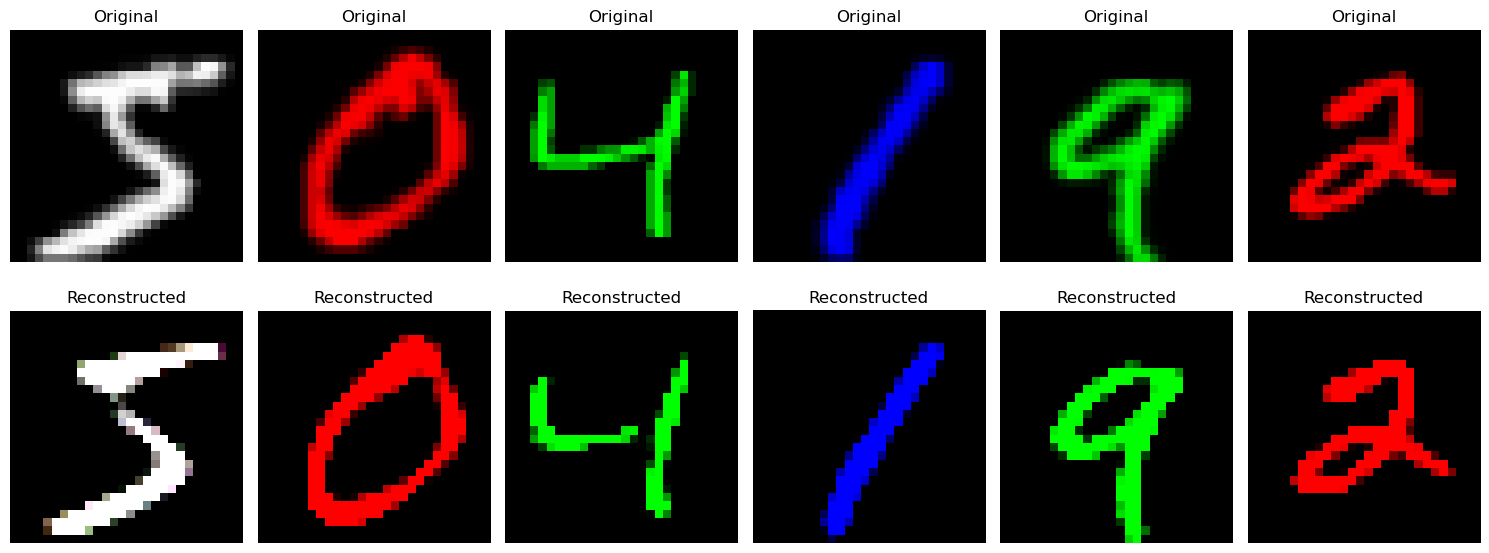

In [18]:
## evaluate autoencoder reconstruction
autoencoder = ConvAutoEncoder()
autoencoder.load_state_dict(torch.load("conv_autoencoder_referential_game.pth"))
test_dataset = Image_Nature(split="test", max_items=1000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
autoencoder.eval()
autoencoder.cpu()
## visualize some reconstructions (e.g., 2 rows of 5 images, red, green, blue, different numbers and sizes)
num_visualize = 6
fig, axes = plt.subplots(2, num_visualize, figsize=(15, 6))
with torch.no_grad():
    for i in range(num_visualize):
        img, _ = test_dataset[i]
        recon_img, _ = autoencoder(img.unsqueeze(0))
        # renormalize for display
        axes[0, i].imshow(img.permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
plt.tight_layout()
plt.show()

### Game Setup and Training

In [26]:
class ImageAlice(nn.Module):
    def __init__(self, latent_dim: int = AE_LATENT_DIM, hidden_dim: int = IMG_HIDDEN_DIM):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, IMG_VOCAB_SIZE)

    def forward(self, target_latent: torch.Tensor):
        x = F.relu(self.fc1(target_latent))
        logits = self.fc2(x)
        dist = torch.distributions.Categorical(logits=logits)
        probs = dist.probs 
        msg = dist.sample()
        log_prob = dist.log_prob(msg)
        entropy = dist.entropy()
        return msg, log_prob, probs, entropy

In [27]:
class ImageBob(nn.Module):
    def __init__(self, latent_dim: int = AE_LATENT_DIM, hidden_dim: int = IMG_HIDDEN_DIM):
        super().__init__()
        self.msg_emb = nn.Embedding(IMG_VOCAB_SIZE, hidden_dim)
        self.img_proj = nn.Linear(latent_dim, hidden_dim)

        # compatibility MLP 
        self.scorer = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, message: torch.Tensor, candidates: torch.Tensor):
        # message: (B)
        # candidates: (B, K, latent_dim)
        msg_vec = self.msg_emb(message).unsqueeze(1)  # (B,1,H)
        img_feats = self.img_proj(candidates)         # (B,K,H)

        # normalization
        msg_vec = msg_vec.expand(-1, candidates.size(1), -1)  # (B,K,H)
        scores = self.scorer(torch.cat([img_feats, msg_vec], dim=-1)).squeeze(-1)
        dist = torch.distributions.Categorical(logits=scores)
        probs = dist.probs
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action, log_prob, probs, entropy

In [28]:
class ImageCentralizedCritic(nn.Module):
    def __init__(self, latent_dim: int = AE_LATENT_DIM, hidden_dim: int = IMG_HIDDEN_DIM):
        super().__init__()
        # self.fc1 = nn.Linear(latent_dim + IMG_VOCAB_SIZE, hidden_dim)
        self.img_encoder = nn.Linear(latent_dim, hidden_dim)
        self.msg_embedding = nn.Embedding(IMG_VOCAB_SIZE, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * (IMG_K_IMAGES +1), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, candidates: torch.Tensor, message: torch.Tensor):

        # candidates: (B, K, latent_dim)
        # message: (B)
        batch_size = candidates.size(0)
        k = candidates.size(1)
        candidates = candidates.view(batch_size * k, -1)  # (B*K, latent_dim) 

        # Encode candidates 
        candidates_encoded = F.relu(self.img_encoder(candidates))  # (B*K, H)
        candidates_flat = candidates_encoded.view(batch_size, -1)  # (B, K*H)
        # Encode message
        msg_emb = self.msg_embedding(message)                       # (B, H)
        msg_emb_flat = msg_emb.view(batch_size, -1)                # (B, H)
        # Concatenate
        critic_input = torch.cat([candidates_flat, msg_emb_flat], dim=-1)  # (B, K*H + H)


        # critic_input = torch.cat([candidates_flat, msg_onehot_flat], dim=1)  # (B*K, latent_dim + Vocab)
        # critic_input = candidates_flat  # (B*K, latent_dim)
        h = F.relu(self.fc1(critic_input))
        values = self.fc2(h)  # (B, K)

        return values  # return value for the first candidate

In [ ]:
def train_referential_game(ae: ConvAutoEncoder, dataset: Dataset, verbose=False, device=torch.device("cpu"), writer=None):
    ae.eval()
    ae.to(device)
    alice = ImageAlice().to(device)
    bob = ImageBob().to(device)
    critic = ImageCentralizedCritic().to(device)
    params = list(alice.parameters()) + list(bob.parameters()) + list(critic.parameters())
    optimizer = optim.Adam(params, lr=IMG_LEARNING_RATE)

    running_reward = 0.0
    history = []

    pbar = tqdm.tqdm(np.arange(IMG_EPISODES), desc="Training referential game")
    for episode in pbar:
        imgs, _ = sample_batch(dataset, IMG_BATCH_SIZE, IMG_K_IMAGES)
        imgs = imgs.to(device)
        B, K, C, H, W = imgs.shape
        imgs = imgs.reshape(B*K, C, H, W) 

        with torch.no_grad():
            latents = ae.encode(imgs)
            latents = latents.view(B, K, -1) # (B, K, latent_dim)
            latents = latents / (latents.norm(dim=-1, keepdim=True) + 1e-8)

        perm = torch.randperm(IMG_K_IMAGES) # randomized permutation to avoid bmm symmetry
        latents = latents[:, perm]
        target_index = (perm == 0).nonzero(as_tuple=True)[0].item()
        target_latent = latents[:, target_index, :]
        # print(target_latent.shape)
        message, alice_lp, _, alice_entropy = alice(target_latent)
        guess_idx, bob_lp, _, bob_entropy = bob(message, latents)

        rewards = (guess_idx == target_index).float()
        mean_r = rewards.mean().item()
        values = critic(latents, message).squeeze()
        advantages = rewards - values.detach()
        # normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


        annealed_BETA =  BETA * max(0.2, (1 - episode / IMG_EPISODES))
        critic_loss = F.mse_loss(values, rewards)
        alice_loss = - (alice_lp * advantages).mean()
        bob_loss = - (bob_lp * advantages).mean()
        entropy = - annealed_BETA * (alice_entropy.mean() + bob_entropy.mean())

        loss = critic_loss + alice_loss + bob_loss + entropy

        torch.nn.utils.clip_grad_norm_(params, 1.0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # register tensorboard logs
        if writer is not None:
            writer.add_scalar('Game/total_loss', loss.item(), episode)
            writer.add_scalar('Game/rewards', mean_r, episode)

        history.append(mean_r)
        pbar.set_postfix({
            "loss": loss.item(),
            "reward": mean_r
        })
        if episode % 500 == 0 and verbose:
            print(f"Ref ep {episode}: acc {mean_r:.3f}")

    return alice, bob, history


In [ ]:
def get_digit_prototypes(mnist):
    """
    Returns: dict[digit] -> PIL image
    """
    prototypes = {}
    for img, digit in mnist:
        if digit not in prototypes:
            prototypes[digit] = img
        if len(prototypes) == 10:
            break
    return prototypes

import itertools
import torch
from torchvision.transforms.functional import pil_to_tensor
def sample_all_combinations(
    dataset: Image_Nature,
    digits=range(10)
):
    """
    Get all combinations of images
    Returns:
        imgs:  (N, 3, 28, 28)
        attrs: (N, 3)  [digit, color_idx, scale_idx]
    """

    mnist = dataset.base
    digit_imgs = get_digit_prototypes(mnist)

    combos = list(itertools.product(
        digits,
        range(len(dataset.colors)),
        range(len(dataset.scales))
    ))

    imgs = []
    attrs = []

    for digit, color_idx, scale_idx in combos:
        img = digit_imgs[digit]
        img_t = pil_to_tensor(img).float() / 255.0  # (1, 28, 28)

        colored = color_transform(img_t.clone(), dataset.colors[color_idx])
        scaled = scale_transform(colored, dataset.scales[scale_idx])

        imgs.append(scaled)
        attrs.append([digit, color_idx, scale_idx])

    imgs = torch.stack(imgs, dim=0)
    attrs = torch.tensor(attrs, dtype=torch.long)

    return imgs, attrs

def analyze_strategy(alice, ae, nature):
    
    # get all possible combinations
    imgs, attrs = sample_all_combinations(nature)
    meta_data = [tuple(attrs[i].tolist()) for i in range(attrs.shape[0])]
    B, C, H, W = imgs.shape

    # get Alice's messages
    with torch.no_grad():
        latents = ae.encode(imgs.to(device)).unsqueeze(1)
        _, _, alice_probs, _ = alice(latents)
    msgs = torch.argmax(alice_probs.squeeze(1), dim=1).cpu().numpy()

    titles = ["Digits", "Color", "Scale"]
    n_categories= [10, len(COLOR_CODES), len(SCALE_FACTORS)]
    dist = {}
    for i, (title, n_cat) in enumerate(zip(titles, n_categories)):
        heatmap = np.zeros((IMG_VOCAB_SIZE, n_cat))

        for msg, meta in zip(msgs, meta_data):
            attr_value = meta[i]
            heatmap[msg, attr_value] += 1
        
        row_sums = heatmap.sum(axis=1, keepdims=True)
        heatmap = np.divide(heatmap, row_sums, where=row_sums!=0, out=np.zeros_like(heatmap)) 
        dist[f"P({title} | Message)"] = heatmap


    return dist


### Training single-message referential game with pre-trained Autoencoder

In [ ]:
# define tensorboard writer
from torch.utils.tensorboard import SummaryWriter
import os

# Create a SummaryWriter instance. You can specify a log directory.
# Each run will create a new subdirectory with a timestamp.
log_dir = "runs/referential_game_experiment"
prefix = "train/"
writer = SummaryWriter(os.path.join(log_dir, prefix))

# generate local link to view tensorboard
print(f"TensorBoard logs will be saved to: {os.path.abspath(log_dir)}")
print("To view TensorBoard, run: tensorboard --logdir runs")

TensorBoard logs will be saved to: /Users/yingcai/Cog-Sup/ComputationalLanguageModelling/Project3/runs/referential_game_experiment
To view TensorBoard, run: tensorboard --logdir runs


In [ ]:


nature = Image_Nature()
history_all = []
N_DIGITS = 10
num_runs = 10
D_cos_color_sgm = np.zeros((num_runs, len(COLOR_CODES), len(COLOR_CODES)))
D_cos_Digit_sgm = np.zeros((num_runs, N_DIGITS, N_DIGITS))
D_cos_Size_sgm = np.zeros((num_runs, len(SCALE_FACTORS), len(SCALE_FACTORS)))
autoencoder = ConvAutoEncoder()
autoencoder.load_state_dict(torch.load("conv_autoencoder_referential_game.pth"))
autoencoder.to(device)
autoencoder.eval()
model_params_base_path_alice = "params/Alice"
model_params_base_path_bob = "params/Bob"
history_base_path = "params/history"
if not os.path.exists("params"):
    os.makedirs("params")
    os.makedirs(model_params_base_path_alice)
    os.makedirs(model_params_base_path_bob)
    os.makedirs(history_base_path)

# check if params were saved before
for i in range(10):
    if os.path.exists(f"{model_params_base_path_alice}/run{i}.pth"):
        print(f"Model parameters for run {i} already exist. Skipping training.")
        
        # load models
        trained_alice = ImageAlice().to(device)
        trained_bob = ImageBob().to(device)
        trained_alice.load_state_dict(torch.load(f"{model_params_base_path_alice}/run{i}.pth"))
        trained_bob.load_state_dict(torch.load(f"{model_params_base_path_bob}/run{i}.pth"))
        # load history
        history = np.load(f"{history_base_path}/run{i}.npy").tolist()
        history_all.append(history)
        # analyze strategy
        dist = analyze_strategy(trained_alice, autoencoder, nature)
        D_cos_color_sgm[i] = cosine_distances(dist[f"P(Color | Message)"].T)
        D_cos_Digit_sgm[i] = cosine_distances(dist[f"P(Digits | Message)"].T)
        D_cos_Size_sgm[i] = cosine_distances(dist[f"P(Scale | Message)"].T)
    else:
        print(f"\n=== Training Run {i+1}/{num_runs} for Referential Game ===")
        postfix = f"run_{i}/"
        writer = SummaryWriter(os.path.join(log_dir, prefix, postfix))
        trained_alice, trained_bob, history = train_referential_game(ae=autoencoder, dataset=nature, writer=writer, device=device)
        history_all.append(history)
        torch.save(trained_alice.state_dict(), f"{model_params_base_path_alice}/run{i}.pth")
        torch.save(trained_bob.state_dict(), f"{model_params_base_path_bob}/run{i}.pth")
        np.save(f"{history_base_path}/run{i}.npy", np.array(history))
        # analyze strategy
        dist = analyze_strategy(trained_alice, autoencoder, nature)
        D_cos_color_sgm[i] = cosine_distances(dist[f"P(Color | Message)"].T)
        D_cos_Digit_sgm[i] = cosine_distances(dist[f"P(Digits | Message)"].T)
        D_cos_Size_sgm[i] = cosine_distances(dist[f"P(Scale | Message)"].T)

Using device: mps
Model parameters for run 0 already exist. Skipping training.
Model parameters for run 1 already exist. Skipping training.
Model parameters for run 2 already exist. Skipping training.
Model parameters for run 3 already exist. Skipping training.
Model parameters for run 4 already exist. Skipping training.
Model parameters for run 5 already exist. Skipping training.


/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_43079/1405233832.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("conv

Model parameters for run 6 already exist. Skipping training.
Model parameters for run 7 already exist. Skipping training.
Model parameters for run 8 already exist. Skipping training.
Model parameters for run 9 already exist. Skipping training.


/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_43079/1405233832.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_alice.load_state_dict(torch.load(f"{

### Inspecting strategy

In [ ]:
D_cos_Digit_sgm.shape

(10, 20, 10)

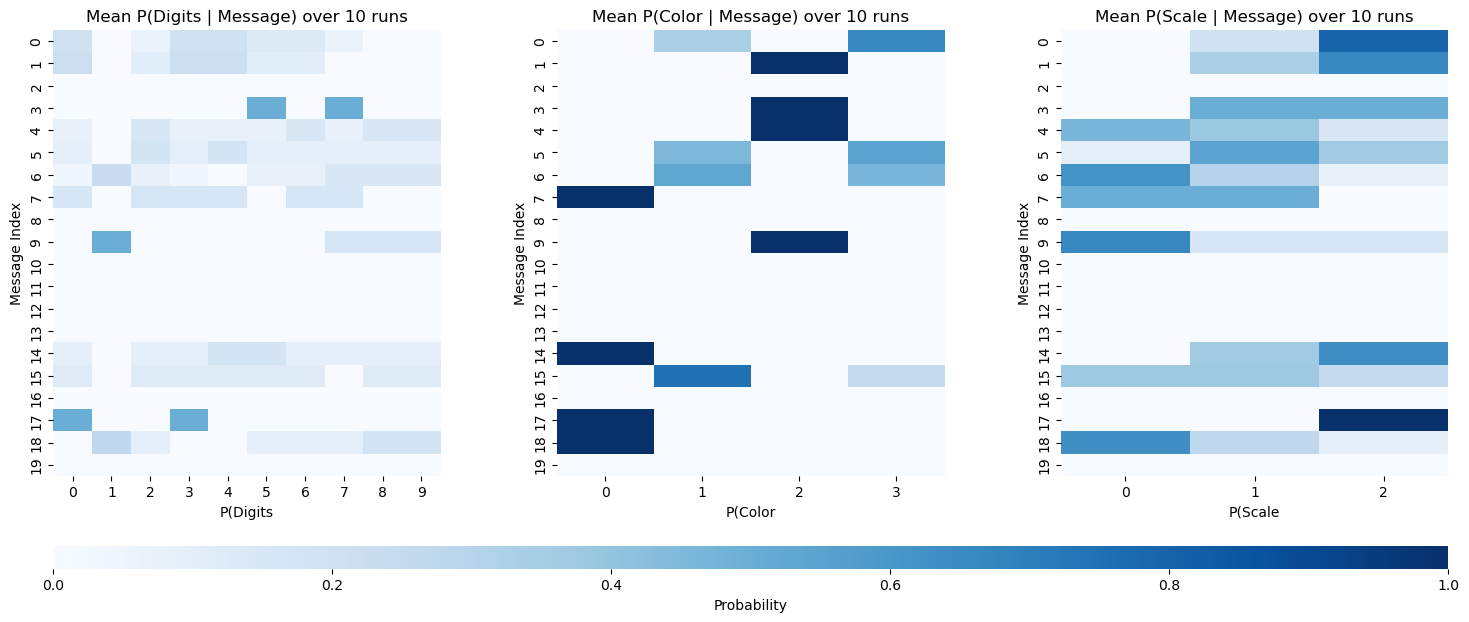

In [ ]:
# conditional probability heatmaps
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(2, 3, wspace=0.3, hspace=0.3, height_ratios=[20, 1])
axes = np.empty((3,), dtype=object)
for i in range(3):
    axes[i] = fig.add_subplot(gs[0, i])

# add a common colorbar axis at the bottom spanning all columns 
cbar_ax = fig.add_subplot(gs[1, :])
for i, cond in enumerate(dist.keys()):
    sns.heatmap(
        dist[cond],
        ax=axes[i],
        cmap='Blues',
        vmin=0, vmax=1,
        cbar = (i==0),
        cbar_ax = cbar_ax if i==0 else None,
        cbar_kws={'label': 'Probability', 'orientation': 'horizontal'},
    )
    axes[i].set_title(f"Mean {cond} over {num_runs} runs")
    axes[i].set_xlabel(cond.split('|')[0].strip())
    axes[i].set_ylabel('Message Index')

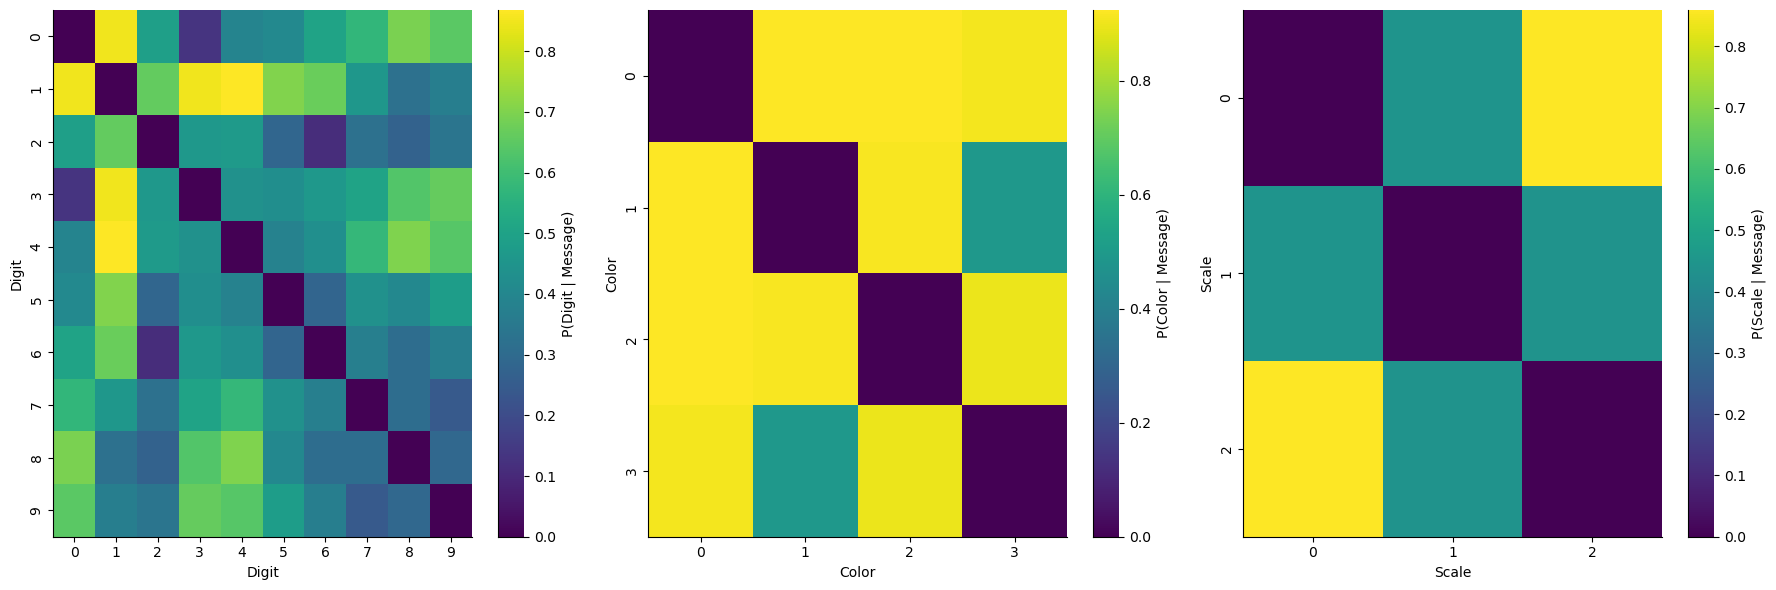

In [ ]:
# average pairwise cosine similarity between message distributions for different digits/colors/sizes
D_cos_digit_sgm_avg = np.mean(D_cos_Digit_sgm, axis=0)
D_cos_color_sgm_avg = np.mean(D_cos_color_sgm, axis=0)
D_cos_size_sgm_avg = np.mean(D_cos_Size_sgm, axis=0)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(D_cos_digit_sgm_avg, cmap='viridis', cbar_kws={'label': 'P(Digit | Message)'}, ax=axes[0])
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Digit")
sns.heatmap(D_cos_color_sgm_avg, cmap='viridis', cbar_kws={'label': 'P(Color | Message)'}, ax=axes[1])
axes[1].set_xlabel("Color")
axes[1].set_ylabel("Color")
sns.heatmap(D_cos_size_sgm_avg, cmap='viridis', cbar_kws={'label': 'P(Scale | Message)'}, ax=axes[2])
axes[2].set_xlabel("Scale")
axes[2].set_ylabel("Scale")
sns.despine()
plt.tight_layout()
plt.show()

### Inspecting Learning Curve

In [ ]:
# Plot input vs message distances
smooth_curve_mean_img, mean_history_img, std_history_wihtout_critic = smooth_curve_mean(history_all)

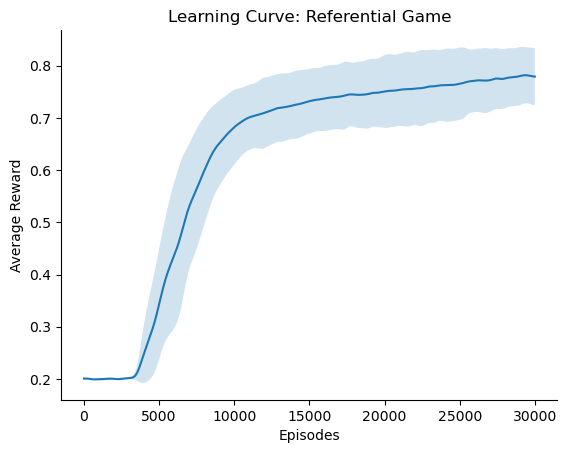

In [ ]:
sns.lineplot(x=np.arange(IMG_EPISODES), y=mean_history_img)
plt.fill_between(np.arange(IMG_EPISODES),
                 mean_history_img - std_history_wihtout_critic,
                 mean_history_img + std_history_wihtout_critic, alpha=0.2)
sns.despine()
plt.title('Learning Curve: Referential Game')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()

## LSTM Agent for multi-message game

### Agent Setup


In [19]:
## Agent Parameters
IMG_LATENT_DIM = AE_LATENT_DIM
LSTM_LATENT_DIM  = 16
VOCAB_SIZE  = 10
MAX_LEN  = 5
EOS_TOKEN  = 0

alicecfg = {
    "img_latent_dim": IMG_LATENT_DIM,
    "lstm_hidden_dim":LSTM_LATENT_DIM,
    "vocab_size": VOCAB_SIZE,
    "max_len": MAX_LEN,
    "eos": EOS_TOKEN,
    "device":device,
}
bobcfg = {
    "img_latent_dim": IMG_LATENT_DIM,
    "lstm_hidden_dim":LSTM_LATENT_DIM,
    "vocab_size": VOCAB_SIZE,
    "eos": EOS_TOKEN,
    "device":device,
}
criticcfg = {
    "img_latent_dim": IMG_LATENT_DIM,
    "lstm_hidden_dim":LSTM_LATENT_DIM,
    "vocab_size": VOCAB_SIZE,
    "eos": EOS_TOKEN,
    "device":device,
}
cfgs = (alicecfg, bobcfg, criticcfg)

In [20]:
## Algorithm Params
IMG_EPISODES = 3e5
IMG_BATCH_SIZE = 64
IMG_LEARNING_RATE = 1e-4
IMG_K_IMAGES = 5
BETA = 0.05

In [21]:
class LSTMImageAlice(nn.Module):

    def __init__(self, img_latent_dim, lstm_hidden_dim, vocab_size, max_len, eos, device):
        
        
        super().__init__()
        self.eos = eos
        self.img_latent_dim = img_latent_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.vocab_size = vocab_size        
        self.max_len = max_len

        self.embedding = nn.Embedding(self.vocab_size, self.lstm_hidden_dim)
        self.fc1 = nn.Sequential(
            nn.Linear(self.img_latent_dim, self.lstm_hidden_dim),
            nn.ReLU()
        )

        self.lstm_cell =nn.LSTMCell(self.lstm_hidden_dim * 2, self.lstm_hidden_dim) 
        self.output = nn.Linear(self.lstm_hidden_dim, self.vocab_size) 

        self.device = device 

    def forward(self, target_input):
        # target_input: (Batch, img_latent_dim)
        
        # start with zero-vector embedding
        B, _ = target_input.shape
        curr_input = torch.zeros(target_input.size(0), self.lstm_hidden_dim).to(target_input.device)
        self.h = torch.zeros(B, self.lstm_hidden_dim, device=target_input.device)
        self.c = torch.zeros(B, self.lstm_hidden_dim, device=target_input.device)

        log_probs = []
        entropy = []
        messages = [] # List of (Batch) tensors
        probs = []

        # Active mask (1 if sentence continues, 0 if ended)
        active_mask = torch.ones(target_input.size(0)).to(target_input.device)

        img_emb = self.fc1(target_input) 

        for t in range(self.max_len):
            inp = torch.cat([img_emb, curr_input], dim=-1)
            self.h, self.c = self.lstm_cell(inp, (self.h, self.c))
            logits = self.output(self.h)

            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()

            # Save stats
            probs.append(dist.probs)
            log_probs.append(dist.log_prob(action) * active_mask)
            entropy.append(dist.entropy() * active_mask)
            messages.append(action)

            # Update inputs for next step
            curr_input = self.embedding(action)

            # Update mask: if action was EOS (0), mask becomes 0
            is_eos = (action == self.eos).float()
            active_mask = active_mask * (1 - is_eos)

        return torch.stack(messages, dim=1), torch.stack(log_probs, dim=1), torch.stack(entropy, dim=1), torch.stack(probs, dim=1) 

class LSTMImageBob(nn.Module):

    def __init__(self, img_latent_dim, lstm_hidden_dim, vocab_size, eos, device):

        super().__init__()

        
        self.eos = eos
        self.img_latent_dim = img_latent_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.vocab_size = vocab_size        
        

        self.msgemb = nn.Embedding(self.vocab_size, self.lstm_hidden_dim) 
        self.lstm = nn.LSTM(self.lstm_hidden_dim, self.lstm_hidden_dim, batch_first=True) 
        self.img_encoder = nn.Linear(self.img_latent_dim, self.lstm_hidden_dim)
        self.scorer = nn.Sequential(
            nn.Linear(2*lstm_hidden_dim, lstm_hidden_dim),
            nn.ReLU(),
            nn.Linear(lstm_hidden_dim, lstm_hidden_dim//2),
            nn.ReLU(),
            nn.Linear(lstm_hidden_dim//2, 1) 
        )

        # hidden state init
        self.h = None
        self.c = None

        self.device = device 

    def forward(self, messages, candidates):
        # messages: (Batch, Seq_Len)
        # candidates: (Batch, K, Input_Dim)

        # 1. Encode Message
        # Embed indices
        x = self.msgemb(messages) # (Batch, Seq, Hidden)

        # Run LSTM. We only care about the final hidden state
        # (Assuming the network learns to ignore padding after EOS or EOS is final)
        _, (self.h, _) = self.lstm(x)
        msg_rep = self.h.squeeze(0).unsqueeze(1) # (Batch, 1, Hidden)
        # msg normalization
        msg_reps = msg_rep.expand(-1, candidates.size(1), -1) # (B, K, Hidden) 

        # 2. Encode Images
        img_reps = self.img_encoder(candidates) # (Batch, K, Hidden)
        img_reps = img_reps - img_reps.mean(dim=1, keepdim=True)  # center normalization

        # 3. Attention / Dot Product
        scores = self.scorer(torch.cat([img_reps, msg_reps], dim=-1)).squeeze(-1)
        dist = torch.distributions.Categorical(logits=scores)
        probs = dist.probs
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        return action, log_prob, entropy, probs

class LSTMImageCentralizedCritic(nn.Module):

    def __init__(self, img_latent_dim, lstm_hidden_dim, vocab_size, eos, device):

        super().__init__()
        
        self.eos = eos
        self.img_latent_dim = img_latent_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.vocab_size = vocab_size        

        self.msg_emb = nn.Embedding(vocab_size, lstm_hidden_dim)
        self.msg_lstm = nn.LSTM(lstm_hidden_dim, lstm_hidden_dim, batch_first=True)

        self.z_proj = nn.Linear(img_latent_dim, lstm_hidden_dim)
        self.head = nn.Sequential(
            nn.Linear(2*lstm_hidden_dim, lstm_hidden_dim),
            nn.ReLU(),
            nn.Linear(lstm_hidden_dim, 1),
        )
        self.device = device 

    def forward(self, z_target, message):
        # message: (B,T) with EOS inside
        # z_target: (B, 1, T)
        B, T = message.shape
        x = self.msg_emb(message)               # (B,T,H)
        h_seq, _ = self.msg_lstm(x)             # (B, T, H)

        z_h = self.z_proj(z_target)             # (B,H)
        z_h = z_h.unsqueeze(1).expand(B, T, -1) # (B, T, H)
        v = self.head(torch.cat([z_h, h_seq], dim=-1)).squeeze(-1)  # (B,)
        return v


In [22]:
def mask_after_eos(msg, eos=0):
    # msg: (B,T)
    B, T = msg.shape
    out = msg.clone()
    ended = torch.zeros(B, dtype=torch.bool, device=msg.device)
    for t in range(T):
        out[ended, t] = eos
        ended |= (msg[:, t] == eos)
    return out

def prefix_mask_from_eos(message, eos_id):
    """
    message: (B,T)
    returns mask: (B,T) with 1 up to and including first EOS, else 0 afterwards
    """
    B, T = message.shape
    is_eos = (message == eos_id).int()                 # (B,T)
    eos_cum = torch.cumsum(is_eos, dim=1)              # (B,T)
    mask = (eos_cum <= 1).float()                      # allow tokens up to first EOS
    return mask

In [23]:
def train_lstm_referential_game(ae:ConvAutoEncoder, dataset, cfgs, verbose=False, device=torch.device("cpu"), writer=None):
    
    alicecfg, bobcfg, criticcig = cfgs
    ae.eval()
    ae.to(device)
    alice = LSTMImageAlice(**alicecfg).to(device)
    bob = LSTMImageBob(**bobcfg).to(device)
    critic = LSTMImageCentralizedCritic(**criticcfg).to(device)
    params = list(alice.parameters()) + list(bob.parameters()) + list(critic.parameters())
    optimizer = optim.Adam(params, lr=IMG_LEARNING_RATE)

    running_reward = 0.0
    history = []

    pbar = tqdm.tqdm(np.arange(IMG_EPISODES), desc="Training referential game")
    for episode in pbar:
        imgs, _ = sample_batch(dataset, IMG_BATCH_SIZE, IMG_K_IMAGES)
        imgs = imgs.to(device)
        B, K, C, H, W = imgs.shape
        imgs = imgs.reshape(B*K, C, H, W) 

        with torch.no_grad():
            latents = ae.encode(imgs)
            latents = latents.view(B, K, -1) # (B, K, latent_dim)
            latents = latents / (latents.norm(dim=-1, keepdim=True) + 1e-8)

        perm = torch.randperm(IMG_K_IMAGES) # randomized permutation to avoid bmm symmetry
        latents = latents[:, perm]
        target_index = (perm == 0).nonzero(as_tuple=True)[0].item()
        target_latent = latents[:, target_index, :]
        # print(target_latent.shape)
        message, alice_lp, alice_entropy, _ = alice(target_latent)
        message = mask_after_eos(message, eos=EOS_TOKEN)
        guess_idx, bob_lp, bob_entropy, _ = bob(message, latents)

        rewards = (guess_idx == target_index).float()
        mask = prefix_mask_from_eos(message, EOS_TOKEN)
        values = critic(target_latent, message)
        mean_r = rewards.mean().item()
        R_seq = rewards.unsqueeze(1).expand_as(values)

        advantages = R_seq - values.detach()
        # normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


        annealed_BETA =  BETA * max(0.2, (1 - episode / IMG_EPISODES))
        critic_loss = 0.5* (((values-R_seq)**2)*mask).sum()/ (mask.sum()+1e-8) 
        alice_loss = - ((alice_lp * advantages.unsqueeze(1))*mask).sum(dim=1).mean()
        bob_loss = - (bob_lp * advantages[:, 0].detach()).mean()
        entropy = - annealed_BETA * ((alice_entropy*mask).sum()/(mask.sum() + 1e-8) + (bob_entropy).mean())

        loss = critic_loss + alice_loss + bob_loss + entropy

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        optimizer.step()

        # register tensorboard logs
        if writer is not None:
            writer.add_scalar('Game/total_loss', loss.item(), episode)
            writer.add_scalar('Game/rewards', mean_r, episode)

        history.append(mean_r)
        pbar.set_postfix({
            "loss": loss.item(),
            "reward": mean_r
        })
        if episode % 500 == 0 and verbose:
            print(f"Ref ep {episode}: acc {mean_r:.3f}")

    return alice, bob, history


### Training

In [24]:
### # Create a SummaryWriter instance. You can specify a log directory.
# Each run will create a new subdirectory with a timestamp.
log_dir = "runs/referential_game_experiment"
prefix = "trainLSTM/"
# generate local link to view tensorboard
print(f"TensorBoard logs will be saved to: {os.path.abspath(log_dir)}")
print("To view TensorBoard, run: tensorboard --logdir runs")

TensorBoard logs will be saved to: /Users/yingcai/Cog-Sup/ComputationalLanguageModelling/Project3/runs/referential_game_experiment
To view TensorBoard, run: tensorboard --logdir runs


In [32]:
postfix = f"test"
writer = SummaryWriter(os.path.join(log_dir, prefix, postfix))
autoencoder = ConvAutoEncoder().to(device)
autoencoder.load_state_dict(torch.load("conv_autoencoder_referential_game.pth"))
nature = Image_Nature()
trained_alice, trained_bob, history = train_lstm_referential_game(ae=autoencoder, dataset=nature, cfgs=cfgs, writer=writer, device=device)

/var/folders/hn/qgh15wdx4tg70d4mtjz4c3yc0000gp/T/ipykernel_1885/1785162344.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("conv_a

Training referential game:   0%|          | 0/300000 [00:00<?, ?it/s]

<Axes: >

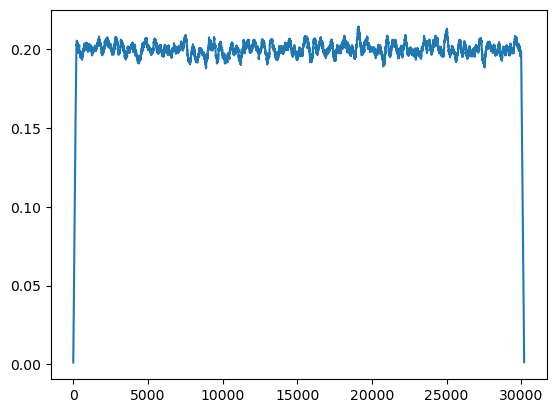

In [ ]:
sns.lineplot(np.convolve(history, np.ones(200)/200))